In [505]:
!pip install tdigest

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp39-cp39-macosx_10_9_x86_64.whl size=62221 sha256=0aad111351826729406687eec9b0f714e223a49ef6da645288bad2e4830428c1
  Stored in directory: /Users/clu/Library/Caches/pip/wheels/17/3a/91/6fcd907a25b48449fb3828081a8d8dc47ab4d4f909dda12ae0
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2190 sha256=52fcc5f2ca9dfdd9fd2f8eb87e37e3457db19917b88f25c7e9e9ec63de1cba3b
  Stored in directory: /Users/clu/Library/Caches/pip/wheels/f7/74/33/b3370ceb7ccc435f8d3e2d4bc30b885b4d95aad8e3628e280d
Successfully built accumulation-tree pyudorandom


In [506]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import cvxpy
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
reload(cp)
reload(ts)

<module 'src.temperature' from '/Users/clu/repos/federated-conformal/src/temperature.py'>

In [2]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [3]:
path_to_experiments = Path('../experiments/')

In [507]:
digest = TDigest()

In [508]:
digest.batch_update(np.random.randn(100))

In [510]:
digest2 = TDigest()
digest2.batch_update(np.random.randn(100))

In [511]:
digest3 = TDigest()
digest3.batch_update(np.random.randn(100))

In [512]:
digest4 = digest + digest2 + digest3

In [520]:
digest4.percentile(99)

2.141634357070453

In [515]:
digest4.percentile(0.9)

-2.3584275332037072

In [628]:
dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
dataset = 'fitzpatrick'

if dataset == 'fitzpatrick':
    model = 'resnet18'
else:
    model = 'small_resnet14'

if dataset in ('mnist', 'svhn', 'cifar10', 'fashion'):
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
        'client_9': [8],
        'client_10': [9],
    }
    num_classes = 10
elif dataset == 'cifar100':
    num_classes = 100
    clients_class_map = {
        "client_1": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        "client_2": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        "client_3": [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        "client_4": [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        "client_5": [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        "client_6": [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        "client_7": [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        "client_8": [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        "client_9": [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        "client_10": [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
    }
    
elif dataset in ('bloodmnist', 'tissuemnist'):
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
    }
    num_classes = 8
elif dataset == 'dermamnist':
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
    }
    num_classes = 7
elif dataset == 'pathmnist':
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
        'client_9': [8],
    }
    num_classes = 9
elif dataset == 'fitzpatrick':
    num_classes = 114
    val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}' / 'val_df.csv')
    test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}' / 'test_df.csv')
    clients_class_map = {}
    # index = test_df.aggregated_fitzpatrick_scale != -1
    # test_df = test_df[index]
    

def load_scores(experiment: Path = None, dataset=None) -> dict:
    try:
        print(experiment)
        load = lambda p: torch.load(p, map_location=torch.device('cpu'))
        stage = 'stage2' if 'tct' in experiment.name else 'stage1'
        val_scores = load(*(experiment / 'scores').glob(f'*_{stage}_val_scores.pth'))
        val_targets = load(*(experiment / 'scores').glob(f'*_{stage}_val_targets.pth'))
        test_scores = load(*(experiment / 'scores').glob(f'*_{stage}_test_scores.pth'))
        test_targets = load(*(experiment / 'scores').glob(f'*_{stage}_test_targets.pth'))
        if dataset in ('bloodmnist', 'dermamnist', 'tissuemnist', 'pathmnist'):
            k = round(0.5 * len(test_targets))
            # k = 50 * len(clients_class_map)
            return dict(val_scores=test_scores[:k], val_targets=test_targets[:k], test_scores=test_scores[k:], test_targets=test_targets[k:])
        else:
            return dict(val_scores=val_scores, val_targets=val_targets, test_scores=test_scores, test_targets=test_targets)
    except Exception as e:
        print(e)
        return None

experiments = {
    # 'central': load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
    'tct': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
    # 'fedavg': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
    # 'tct_iid': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
    # 'fedavg_iid': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
}
experiments = {k: v for k, v in experiments.items() if v is not None}
if dataset == 'fitzpatrick':
    # for k, v in experiments.items():
    #     if k == 'tct':
    #         experiments[k]['test_scores'] = v['test_scores'][index]
    #         experiments[k]['test_targets'] = v['test_targets'][index]
    assert (experiments['tct']['val_targets'].numpy() == val_df['target'].values).sum()
    assert (experiments['tct']['test_targets'].numpy() == test_df['target'].values).sum()

../experiments/fitzpatrick_tct_resnet18


In [620]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

In [630]:
for k, v in experiments.items():
    print(f"\n{k.upper().center(20, '=')}")
    print(f" val accuracy {accuracy(v['val_scores'], v['val_targets']):.0%}  |  {len(v['val_scores'])}")
    print(f"test accuracy {accuracy(v['test_scores'], v['test_targets']):.0%}  |  {len(v['test_scores'])}")



========TCT=========
 val accuracy 40%  |  550
test accuracy 38%  |  1389


## Temperature scaling

In [622]:
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores

## Comparing conformal methods

In [623]:
reload(cp)

<module 'src.conformal' from '/Users/clu/repos/federated-conformal/src/conformal.py'>

In [624]:
experiments['tct']['temp_val_scores'].shape

torch.Size([902, 7])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


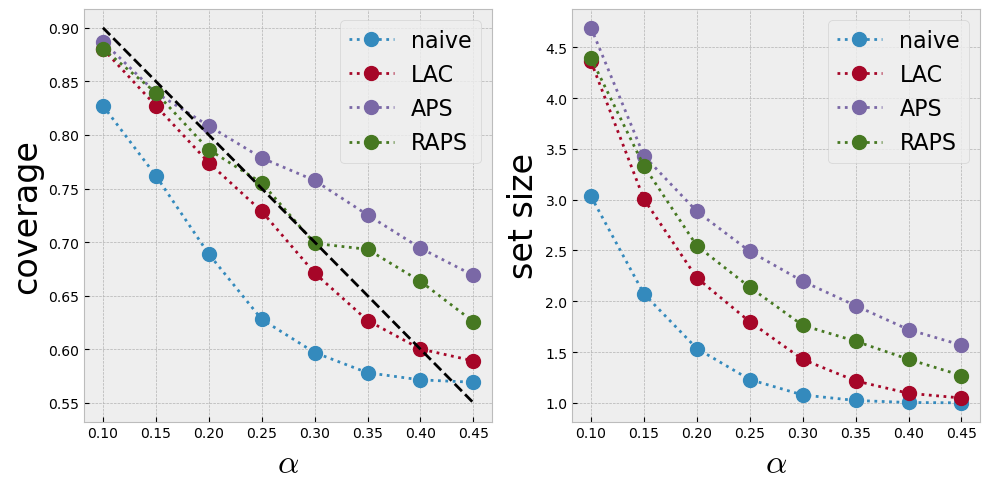

In [627]:
decentral=True
decentral=False
if dataset == 'fitzpatrick':
    client_index_map = {
        str(st): (val_df.aggregated_fitzpatrick_scale == st).values for st in 
        sorted(val_df.aggregated_fitzpatrick_scale.unique())
    }
else:
    client_index_map = {
        k: sum(experiments['tct']['val_targets'] == k for k in v).bool()
        for k, v in clients_class_map.items()
    }
        
fontsize=24
alphas=np.arange(0.10, 0.5, 0.05)
allow_empty_sets = True
allow_empty_sets = False
style = 'o:'
markersize=10

f = itemgetter('temp_val_scores', 'val_targets', 'temp_test_scores', 'test_targets')
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

params = dict(allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=decentral, client_index_map=client_index_map)

naive_lac_metrics = cp.get_coverage_size_over_alphas(*f(experiments['tct']), method='naive_lac', **params)
ax[0].plot(*zip(*naive_lac_metrics['coverage'].items()), style, label='naive', markersize=markersize)
ax[1].plot(*zip(*naive_lac_metrics['size'].items()), style, label='naive', markersize=markersize)

lac_metrics = cp.get_coverage_size_over_alphas(*f(experiments['tct']), method='lac', **params)
ax[0].plot(*zip(*lac_metrics['coverage'].items()), style, label='LAC', markersize=markersize)
ax[1].plot(*zip(*lac_metrics['size'].items()), style, label='LAC', markersize=markersize)

aps_metrics = cp.get_coverage_size_over_alphas(*f(experiments['tct']), method='aps', **params)
ax[0].plot(*zip(*aps_metrics['coverage'].items()), style, label='APS', markersize=markersize)
ax[1].plot(*zip(*aps_metrics['size'].items()), style, label='APS', markersize=markersize)

raps_metrics = cp.get_coverage_size_over_alphas(
    *f(experiments['tct']), method='raps', k_reg=1, lam_reg=0.001, **params
)
ax[0].plot(*zip(*raps_metrics['coverage'].items()), style, label='RAPS', markersize=markersize)
ax[1].plot(*zip(*raps_metrics['size'].items()), style, label='RAPS', markersize=markersize)

ax[0].plot([min(alphas), max(alphas)], [1-min(alphas), 1-max(alphas)], '--', color='black')

ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0].set_ylabel('coverage', fontsize=fontsize)
ax[1].set_ylabel('set size', fontsize=fontsize)
ax[0].legend(fancybox=True, fontsize=fontsize-8, loc='upper right')
ax[1].legend(fancybox=True, fontsize=fontsize-8, loc='upper right')

plt.tight_layout()
plt.savefig(fig_dir / f'experiment-1-{dataset}.eps')
plt.show()

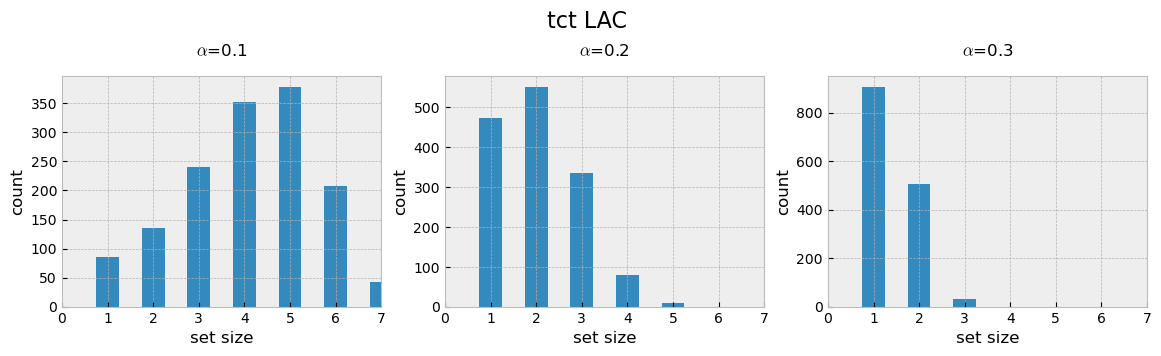

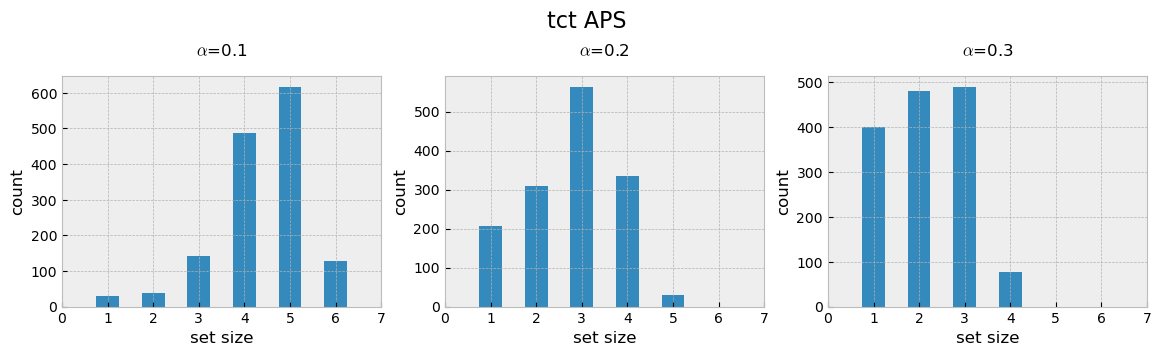

AssertionError: 

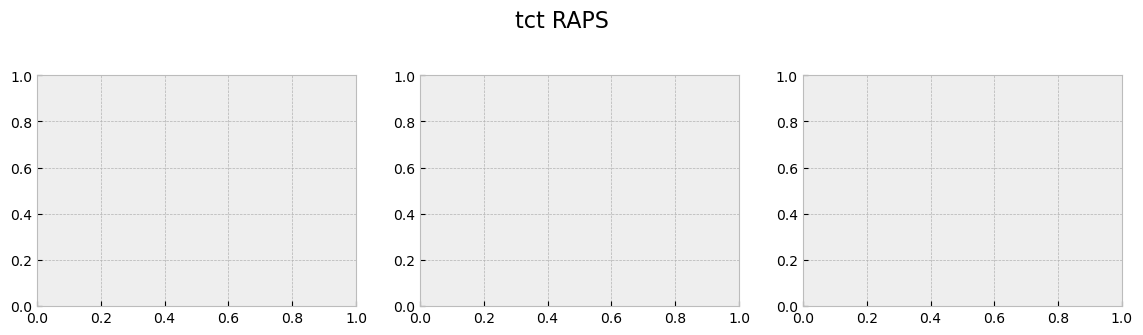

In [607]:
fontsize = 12
allow_empty_sets = False 
# for exp in ('central', 'tct', 'fedavg'):
for exp in experiments.keys():
    val_logits = experiments[exp]['val_scores']
    test_logits = experiments[exp]['test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    temp = ts.tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
    # temp = 1
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)

    fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(exp + ' LAC', fontsize=fontsize+4, y=1.10)
    
    for i, alpha in enumerate((0.1, 0.2, 0.3)):
        lac_q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
        lac_psets = cp.inference_lac(test_scores, lac_q, allow_empty_sets=allow_empty_sets)
        lac_size_counts = lac_psets.sum(1).bincount().tolist()
        ax[i].bar(range(len(lac_size_counts)), lac_size_counts, width=0.5)
        ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
        ax[i].set_xlabel('set size', fontsize=fontsize)
        ax[i].set_ylabel('count', fontsize=fontsize)
        ax[i].set_xlim(0, num_classes)
        
    # fig.tight_layout()
    plt.show()


    fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(exp + ' APS', fontsize=fontsize+4, y=1.10)
    
    for i, alpha in enumerate((0.1, 0.2, 0.3)):
        aps_q = cp.calibrate_aps(val_scores, val_targets, alpha=alpha)
        aps_psets = cp.inference_aps(test_scores, aps_q, allow_empty_sets=allow_empty_sets)
        aps_size_counts = aps_psets.sum(1).bincount().tolist()
        # print(aps_size_counts)
        ax[i].bar(range(len(aps_size_counts)), aps_size_counts, width=0.5)
        ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
        ax[i].set_xlabel('set size', fontsize=fontsize)
        ax[i].set_ylabel('count', fontsize=fontsize)
        ax[i].set_xlim(0, num_classes)
        
    # fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(exp + ' RAPS', fontsize=fontsize+4, y=1.10)
    
    for i, alpha in enumerate((0.1, 0.2, 0.3)):
        raps_q = cp.calibrate_raps(val_scores, val_targets, alpha=alpha, k_reg=10, lam_reg=0.001)
        raps_psets = cp.inference_raps(test_scores, raps_q, allow_empty_sets=allow_empty_sets, k_reg=10, lam_reg=0.001)
        raps_size_counts = raps_psets.sum(1).bincount().tolist()
        ax[i].bar(range(len(raps_size_counts)), raps_size_counts, width=0.5)
        ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
        ax[i].set_xlabel('set size', fontsize=fontsize)
        ax[i].set_ylabel('count', fontsize=fontsize)
        ax[i].set_xlim(0, num_classes)
        
    # fig.tight_layout()
    plt.show()
    
    print(lac_q, aps_q, raps_q)

In [17]:
def plot_conformal(
    conformal_metrics, fontsize=16, title=None, 
    num_classes=None, use_viridis=False, alpha=1, 
    markersize=10, height=4, width=10, save=None, legend_title=None,
):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(width, height))
    # for i, method in enumerate(['lac', 'aps', 'raps']):
    if title:
        fig.suptitle(title, fontsize=fontsize)
    for i, (experiment, metrics) in enumerate(conformal_metrics.items()):
        alphas = metrics['alphas']
        coverage = metrics['coverage']
        size = metrics['size']
        
        if experiment == 'central':
            style = '^-' 
            color = 'C0'
        elif experiment == 'tct':
            style = 'o:'
            color = 'C1'
        elif experiment == 'fedavg':
            style = 'o--'
            color = 'C2'
        elif experiment == 'tct_iid':
            style = 'x:'
            color = 'C3'
        elif experiment == 'fedavg_iid':
            style = 'x--' 
            color = 'C4'
        else:
            style = 'o--'
            color = f'C{i}'
            
        if use_viridis:
            interp_cmap = [round(x) for x in np.linspace(0, 256, len(conformal_metrics) + 1)]
            color = mpl.colormaps['viridis'].colors[interp_cmap[i]]
        
        ax[0].plot(*zip(*coverage.items()), style, label=experiment, c=color, markersize=markersize, alpha=alpha)
        ax[0].plot([0, max(alphas)], [1, 1 - max(alphas)], ':', color='black')
        ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
        ax[0].set_ylabel(r'coverage', fontsize=fontsize)
        # ax[0].set_ylim(0.75, 1)
        ax[0].legend(fontsize=fontsize-4, ncol=2, fancybox=True, title=legend_title, title_fontsize=fontsize-4)

        ax[1].plot(*zip(*size.items()), style, label=experiment, c=color, markersize=markersize, alpha=alpha)
        ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
        ax[1].set_ylabel(r'set size', fontsize=fontsize)
        if num_classes is not None:
            ax[1].set_ylim(0, num_classes)
        ax[1].legend(fontsize=fontsize-4, ncol=2, fancybox=True, title=legend_title, title_fontsize=fontsize-4 )

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

In [ ]:
def tune_temp(logits, labels, binary_search=True, lower=0.2, upper=5.0, eps=0.0001):
    logits = np.array(logits)

    if binary_search:
        import torch
        import torch.nn.functional as F

        logits = torch.FloatTensor(logits)
        labels = torch.LongTensor(labels)
        t_guess = torch.FloatTensor([0.5*(lower + upper)]).requires_grad_()

        while upper - lower > eps:
            if torch.autograd.grad(F.cross_entropy(logits / t_guess, labels), t_guess)[0] > 0:
                upper = 0.5 * (lower + upper)
            else:
                lower = 0.5 * (lower + upper)
            t_guess = t_guess * 0 + 0.5 * (lower + upper)

        t = min([lower, 0.5 * (lower + upper), upper], key=lambda x: float(F.cross_entropy(logits / x, labels)))
    else:
        import cvxpy as cx

        set_size = np.array(logits).shape[0]

        t = cx.Variable()

        expr = sum((cx.Minimize(cx.log_sum_exp(logits[i, :] * t) - logits[i, labels[i]] * t)
                    for i in range(set_size)))
        p = cx.Problem(expr, [lower <= t, t <= upper])

        p.solve()   # p.solve(solver=cx.SCS)
        t = 1 / t.value

    return t


In [ ]:
def plot_interpolated_temp(val_logits, val_targets, test_logits, test_targets, num_interp=5, fontsize=16, title=None, alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], method='aps', allow_empty_sets=False, num_classes=None):
    conformal_metrics = {}
    # T = tune_temp(val_logits, val_targets, False).item()
    T = temp_scale(val_logits, val_targets, False).item()
    for t in [x for x in np.linspace(1, T, num_interp + 1)]:
        conformal_metrics[f'temp={t:.2f}'] = get_conformal_metrics(
            val_logits, val_targets, test_logits, test_targets, 
            alphas=alphas,
            use_temp_scale=True,
            manual_temp=t,
            method=method,
            allow_empty_sets=allow_empty_sets,
        )
    plot_conformal(conformal_metrics, fontsize=fontsize, title=title, num_classes=num_classes, use_viridis=True)
    
# method = 'lac'
method = 'aps'
# method = 'raps'
allow_empty_sets = False
for exp in ('tct', 'fedavg', 'fedavg_iid'):
# for exp in ('central', 'tct', 'fedavg'):
    plot_interpolated_temp(*f(experiments[exp]), title=f'{exp.upper()} / {method.upper()}', method=method, allow_empty_sets=allow_empty_sets, num_classes=num_classes)

## client conditional coverage

In [ ]:
def get_client_accuracy(experiment, clients_class_map):
    test_scores = experiment['test_scores']
    test_targets = experiment['test_targets']

    clients_test_index = {
        client: torch.any(torch.stack([test_targets == label for label in labels]), 0)
        for client, labels in clients_class_map.items()
    }
    def accuracy(scores, targets):
        n = targets.size(0)
        correct = scores.argmax(1) == targets
        return correct.sum() / n
        
    return {client: accuracy(test_scores[index], test_targets[index]).item() 
            for client, index in clients_test_index.items()}

In [810]:
def get_skin_type_accuracy(experiment, test_df):
    results = {}
    skin_types = sorted(test_df.aggregated_fitzpatrick_scale.unique())
    for st in skin_types:
        index = test_df.aggregated_fitzpatrick_scale == st
        scores = experiment['test_scores'][index]
        targets = experiment['test_targets'][index]
        results[st] = accuracy(scores, targets)
    return results
   

In [827]:
test_df.aggregated_fitzpatrick_scale.value_counts()

-1.0    289
 3.0    100
 1.0    100
 2.5    100
 5.5    100
 2.0    100
 1.5    100
 4.0    100
 5.0    100
 3.5    100
 4.5    100
 6.0    100
Name: aggregated_fitzpatrick_scale, dtype: int64

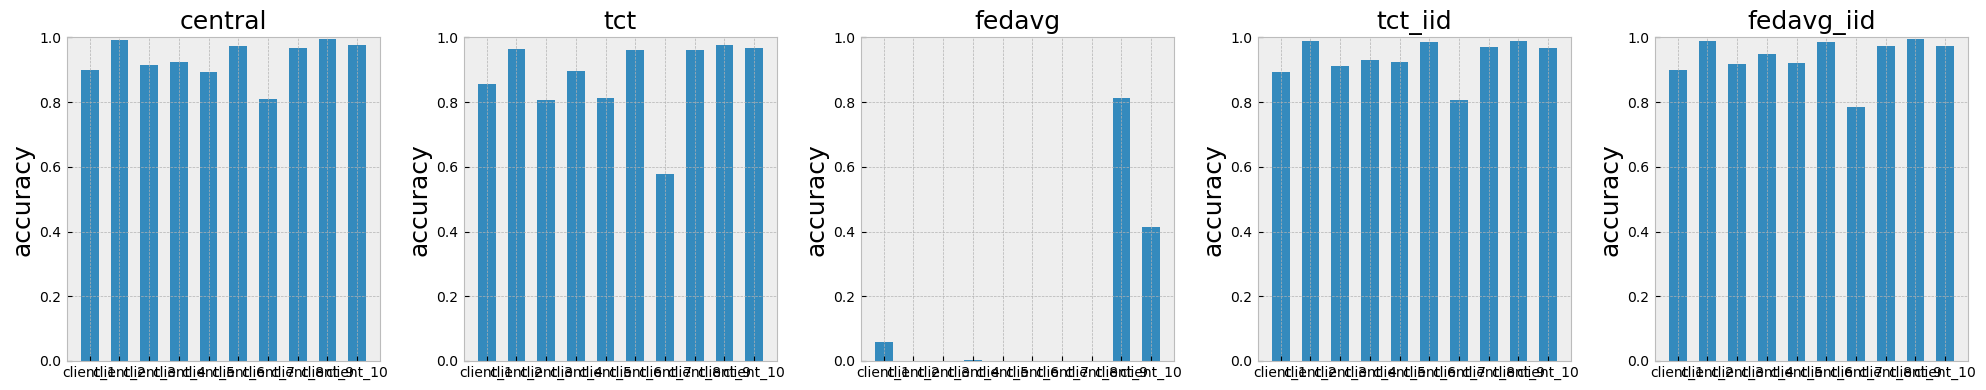

In [811]:
def plot_client_accuracy(experiments, height=4, width=4, fontsize=18, dataset=dataset):
    fig, ax = plt.subplots(ncols=len(experiments), figsize=(width*len(experiments), height))
    for i, (k, v) in enumerate(experiments.items()):
        ax[i].set_title(k, fontsize=fontsize)
        if dataset == 'fitzpatrick':
            ax[i].bar(*zip(*get_skin_type_accuracy(v, test_df).items()), width=0.3)
            ax[i].set_xlabel('skin type', fontsize=fontsize)
        else:
            ax[i].bar(*zip(*get_client_accuracy(v, clients_class_map).items()), width=0.6)
        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel('accuracy', fontsize=fontsize)
    fig.tight_layout()
    plt.show()
    
plot_client_accuracy(experiments, dataset=dataset)

In [828]:
def get_client_conformal_metrics(
    clients_class_map: dict,
    val_logits, val_targets, test_logits, test_targets, 
    alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    use_temp_scale=False,
    method='lac',
    allow_empty_sets=False,
    val_df = None,
    test_df = None,
    k_reg = 1,
    lam_reg = 0.1,
):
    
    if val_df is not None and test_df is not None:
        skin_types = sorted(val_df.aggregated_fitzpatrick_scale.unique())
        clients_val_index = {
            str(st): (val_df.aggregated_fitzpatrick_scale == st).values
            for st in skin_types
        }
        clients_test_index = {
            str(st): (test_df.aggregated_fitzpatrick_scale == st).values
            for st in skin_types
        }
    else:
        # partition clients by class label
        clients_val_index = {
            client: torch.any(torch.stack([val_targets == label for label in labels]), 0)
            for client, labels in clients_class_map.items()
        }

        clients_test_index = {
            client: torch.any(torch.stack([test_targets == label for label in labels]), 0)
            for client, labels in clients_class_map.items()
        }

    global_temp = temp_scale(val_logits, val_targets, False) 
    global_val_scores = torch.softmax(val_logits / (global_temp if use_temp_scale else 1), 1)
    global_test_scores = {
        client: torch.softmax(test_logits[index] / (global_temp if use_temp_scale else 1), 1)
        for client, index in clients_test_index.items()
    }
    
    # temperature scaling
    clients_val_temp = {
        client: temp_scale(val_logits[index], val_targets[index], False) 
        for client, index in clients_val_index.items()
    }
    clients_val_scores = {
        # client: torch.softmax(val_logits[index] / (clients_val_temp[client] if use_temp_scale else 1), 1)
        client: torch.softmax(val_logits[index] / (global_temp if use_temp_scale else 1), 1)
        for client, index in clients_val_index.items()
    }
    clients_test_scores = {
        # client: torch.softmax(test_logits[index] / (clients_val_temp[client] if use_temp_scale else 1), 1)
        client: torch.softmax(test_logits[index] / (global_temp if use_temp_scale else 1), 1)
        for client, index in clients_test_index.items()
    }
    # print(clients_test_scores)
    
    for k, v in clients_val_scores.items():
        assert len(v)
    for k, v in clients_test_scores.items():
        assert len(v)
    
    # choose score function
    if method == 'lac':
        score_func = calibrate_lac
        infer_func = inference_lac
    elif method == 'aps':
        score_func = calibrate_aps
        infer_func = inference_aps
    elif method == 'raps':
        score_func = partial(calibrate_raps, k_reg=k_reg, lam_reg=lam_reg)
        infer_func = partial(inference_raps, k_reg=k_reg, lam_reg=lam_reg)
    else:
        raise ValueError(f'{method} score function not implemented')
        
    # calibrate by estimating quantile in distributed manner
    clients_local_q, clients_decentral_q = defaultdict(dict), defaultdict(dict)
    clients_local_coverage, clients_local_size = defaultdict(dict), defaultdict(dict)
    clients_decentral_coverage, clients_decentral_size = defaultdict(dict), defaultdict(dict)
    clients_global_coverage, clients_global_size = defaultdict(dict), defaultdict(dict)
    
    # compute global quantile (pool all calibration samples together)
    global_q = {alpha: score_func(global_val_scores, val_targets, alpha=alpha) for alpha in alphas}
    
    for client, index in clients_test_index.items():
        scores = clients_test_scores[client]
        targets = test_targets[index] 
        n = targets.shape[0]
        for alpha in alphas:
            global_psets = infer_func(scores, global_q[alpha], allow_empty_sets=allow_empty_sets)
            clients_global_coverage[client][alpha] = global_psets[torch.arange(n), targets].float().mean().item()
            clients_global_size[client][alpha] = global_psets.sum(1).float().mean().item()
    
    decentral_sketch = DDSketch()
    total_cal_samples = 0
    for client, index in clients_val_index.items():
        scores = clients_val_scores[client]
        targets = val_targets[index]
        total_cal_samples += targets.shape[0]
        
        assert len(scores), len(targets)
        
        # store local quantiles at different coverage thresholds to evaluate local coverage
        for alpha in alphas:
            local_q = score_func(scores, targets, alpha=alpha)
            clients_local_q[client][alpha] = local_q
            # print(local_q)
            
        dummy_alpha = 0.1
        _, score_dist = score_func(scores, targets, alpha=dummy_alpha, return_dist=True)
        
        # add client scores to quantile sketcher
        client_sketch = DDSketch()
        for score in score_dist.tolist():
            if method == 'lac':
                client_sketch.add(1 - score)
            else:
                client_sketch.add(score)
        
        # merge client sketcher with decentral sketcher
        decentral_sketch.merge(client_sketch)
        
    # print(*[decentral_sketch.get_quantile_value(q) for q in [0.95, 0.9, 0.8, 0.7, 0.6, 0.5]])
    assert total_cal_samples
        
    for client, index in clients_test_index.items():
        scores = clients_test_scores[client]
        targets = test_targets[index]
        if dataset != 'fitzpatrick':
            assert targets.unique().tolist() == clients_class_map[client], f'{targets.unique()=}'
        n = targets.shape[0]
        # print(n)

        # compute prediction sets with local and distributed quantiles
        for alpha, local_q in clients_local_q[client].items():

            local_psets = infer_func(scores, local_q, allow_empty_sets=allow_empty_sets)
            clients_local_coverage[client][alpha] = local_psets[torch.arange(n), targets].float().mean().item()
            clients_local_size[client][alpha] = local_psets.sum(1).float().mean().item()
            
            # print(f'{total_cal_samples=}')
            if method == 'lac':
                q = np.ceil((total_cal_samples+1)*(alpha))/total_cal_samples
            else:
                q = np.ceil((total_cal_samples+1)*(1-alpha))/total_cal_samples
            decentral_q = decentral_sketch.get_quantile_value(q)
            # print(alpha, q, decentral_q)
            
            clients_decentral_q[client][alpha] = decentral_q
            decentral_psets = infer_func(scores, decentral_q, allow_empty_sets=allow_empty_sets)
            clients_decentral_coverage[client][alpha] = decentral_psets[torch.arange(n), targets].float().mean().item()
            clients_decentral_size[client][alpha] = decentral_psets.sum(1).float().mean().item()

    # combine into format for plotter
    local_metrics = defaultdict(dict)
    decentral_metrics = defaultdict(dict)
    global_metrics = defaultdict(dict)
    if val_df is not None and test_df is not None:
        clients = list(map(str, skin_types))
    else:
        clients = clients_class_map.keys()
    # print(clients_local_coverage)
    for client in clients:
        # print(client)
        local_metrics[client]['alphas'] = alphas
        local_metrics[client]['q'] = clients_local_q[client]
        local_metrics[client]['coverage'] = clients_local_coverage[client]
        local_metrics[client]['size'] = clients_local_size[client]
        
        decentral_metrics[client]['alphas'] = alphas
        decentral_metrics[client]['q'] = clients_decentral_q[client]
        decentral_metrics[client]['coverage'] = clients_decentral_coverage[client]
        decentral_metrics[client]['size'] = clients_decentral_size[client]
        
        global_metrics[client]['alphas'] = alphas
        global_metrics[client]['q'] = global_q
        global_metrics[client]['coverage'] = clients_global_coverage[client]
        global_metrics[client]['size'] = clients_global_size[client]
        
    return local_metrics, decentral_metrics, global_metrics, decentral_sketch, score_dist

{}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


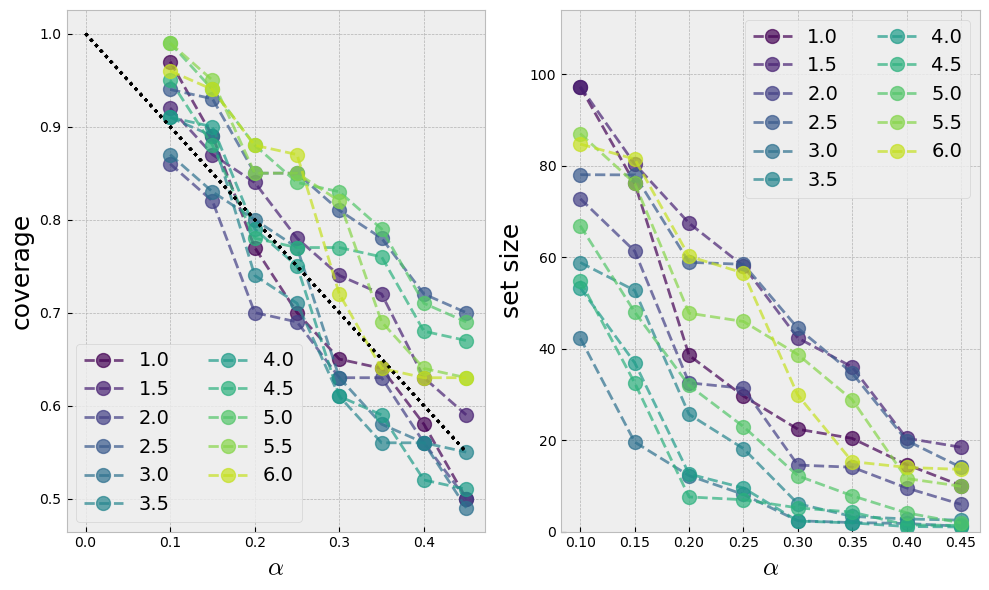

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


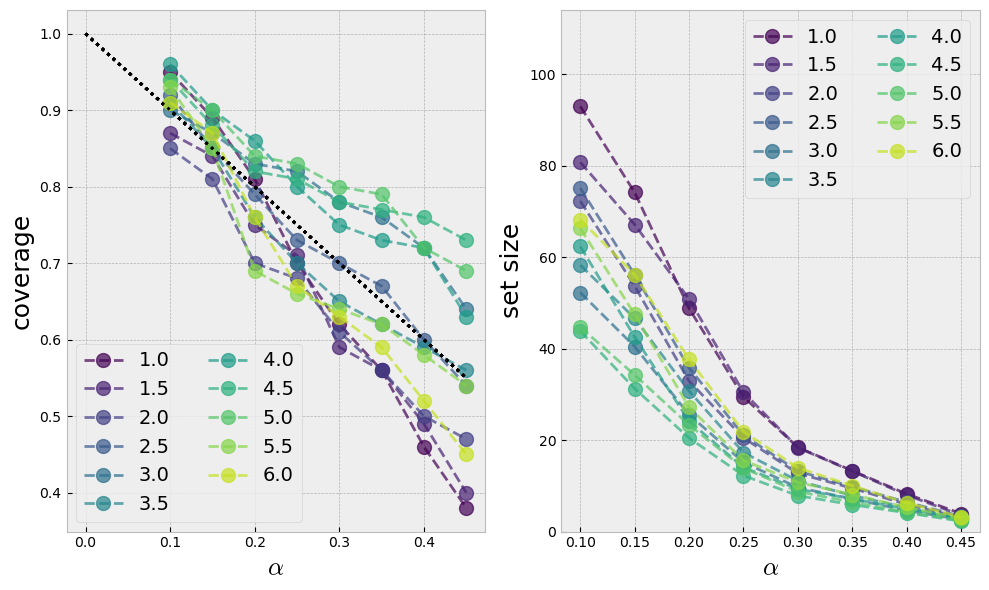

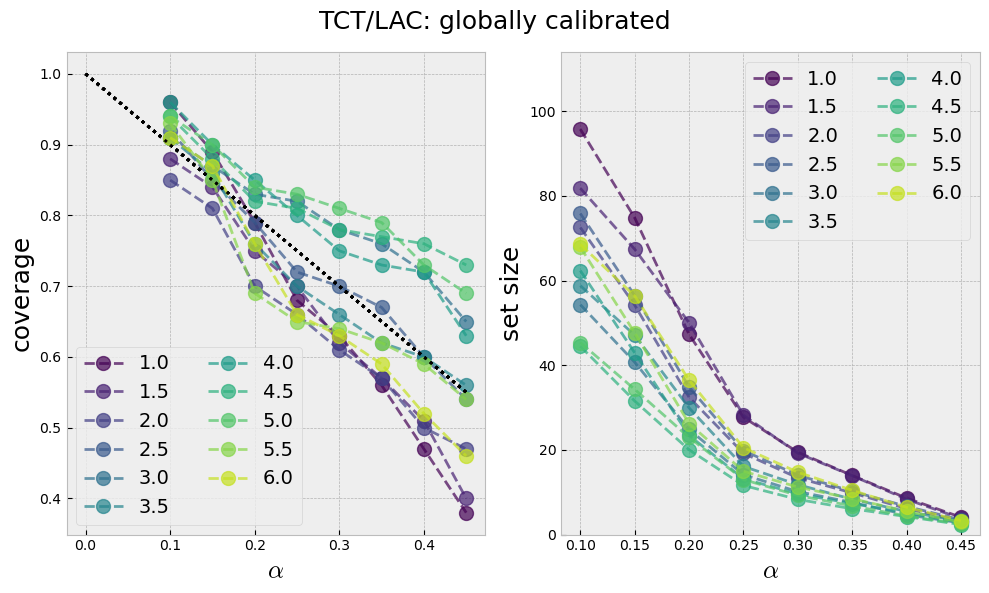

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


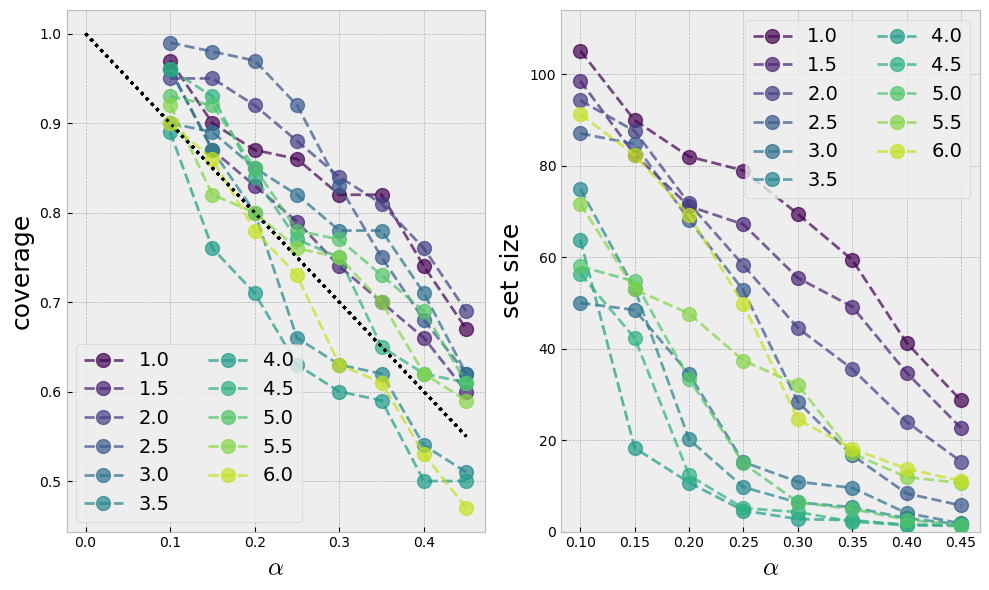

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


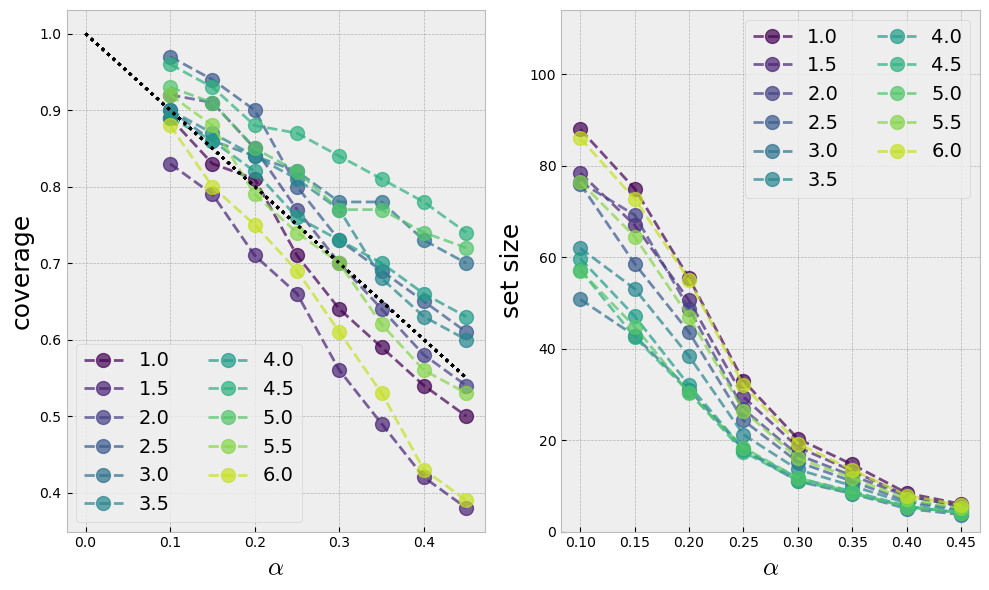

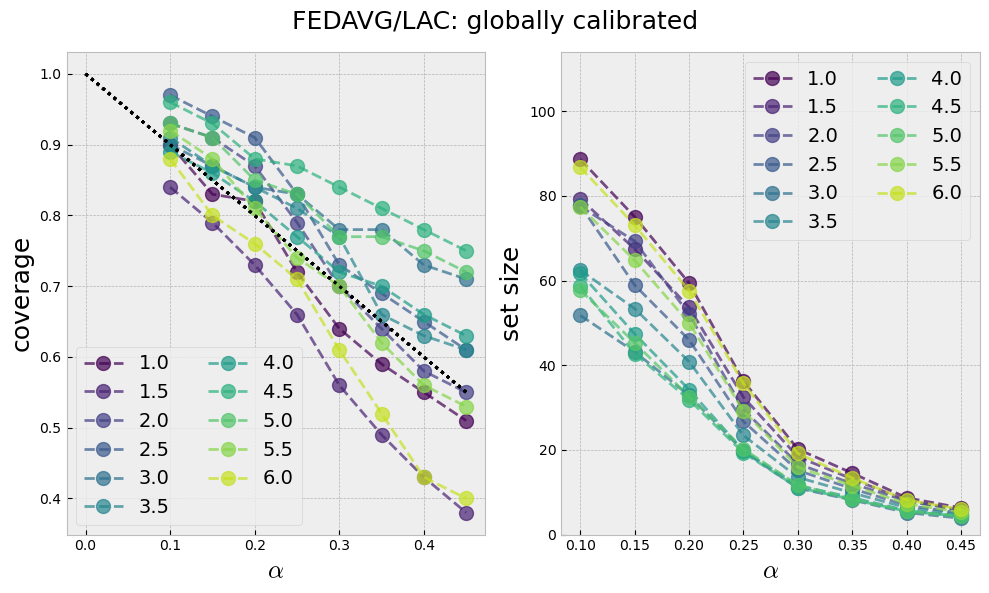

In [830]:
alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
alphas=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
alphas=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
print(clients_class_map)

allow_empty_sets = False
# allow_empty_sets = True
# use_temp_scale = False
use_temp_scale = True
# methods = ('lac', 'aps', 'raps')
methods = ('lac', 'aps')
methods = ('lac', )

for exp in ('tct', 'fedavg'):
# for exp in ('tct', 'tct_iid'):
    for method in methods:
        local_metrics, decentral_metrics, global_metrics, *_ = get_client_conformal_metrics(
            clients_class_map, *f(experiments[exp]), method=method, 
            allow_empty_sets=allow_empty_sets, 
            use_temp_scale=use_temp_scale, alphas=alphas,
            val_df=val_df if dataset=='fitzpatrick' else None, test_df=test_df if dataset=='fitzpatrick' else None,
            k_reg=1, lam_reg=0.0001,
        )
        plot_params = dict(num_classes=num_classes, alpha=0.7, use_viridis=True, height=6, width=10, fontsize=18)
        plot_conformal(
            local_metrics, 
            # title=f'{exp.upper()}/{method.upper()}: locally calibrated', 
            **plot_params, 
            save=fig_dir / f'{dataset}-client-local.eps',
            # legend_title='clients (skin type)',
        )
        plot_conformal(
            decentral_metrics, 
            # title=f'{exp.upper()}/{method.upper()}: decentrally calibrated', 
            **plot_params,
            save=fig_dir / f'{dataset}-client-decentral.eps',
            # legend_title='clients (skin type)',
        )
        plot_conformal(global_metrics, title=f'{exp.upper()}/{method.upper()}: globally calibrated', **plot_params)

## size conditional coverage (difficulty)

In [455]:
exp = 'fedavg_iid'
# exp = 'central'
allow_empty_sets = False
val_logits = experiments[exp]['val_scores']
test_logits = experiments[exp]['test_scores']
val_targets = experiments[exp]['val_targets']
test_targets = experiments[exp]['test_targets']
temp = ts.tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
# temp = 1
val_scores = torch.softmax(val_logits / temp, 1)
test_scores = torch.softmax(test_logits / temp, 1)
lac_q = calibrate_lac(val_scores, val_targets, alpha=0.1)
lac_psets = inference_lac(test_scores, lac_q, allow_empty_sets=allow_empty_sets)
lac_size_counts = lac_psets.sum(1).bincount().tolist()
aps_q = calibrate_aps(val_scores, val_targets, alpha=0.1)
aps_psets = inference_aps(test_scores, aps_q, allow_empty_sets=allow_empty_sets)
aps_size_counts = aps_psets.sum(1).bincount().tolist()
print(lac_q)
print(aps_q)

tensor(0.1072)
tensor(0.9966)


In [412]:
def coverage(psets, targets):
    n = psets.shape[0]
    return psets[torch.arange(n), targets].float().mean().item()

def size_cond_coverage(psets, targets, bins=2, minlength=num_classes):

    counts = dict(enumerate(torch.bincount(psets.sum(1), minlength=minlength)))
    results = {}
    for k, v in counts.items():
        if v == 0:
            continue
        index = psets.sum(1) == k
        c = coverage(psets[index], test_targets[index])
        if c != c: continue
        results[k] = c

    binned_results = {}
    for i in range(len(counts) // bins):
        total_counts = 0
        num_sizes = 0
        for j in range(bins):
            index = (i*bins)+j
            if index > len(counts) or index not in results: continue
            total_counts += counts[index]
            num_sizes += 1
        if num_sizes == 0: continue

        # print(total_counts)
        weighted_size = 0.
        weighted_coverage = 0
        for j in range(bins):
            index = (i*bins)+j
            # print(index)
            if index > len(counts) or index not in results: continue
            w = counts[index] / total_counts
            # print(w, counts[index])
            weighted_size += index 
            weighted_coverage += results[index] * w
        # print(weighted_coverage)
        weighted_size /= num_sizes
        binned_results[weighted_size] = weighted_coverage
        
    return binned_results

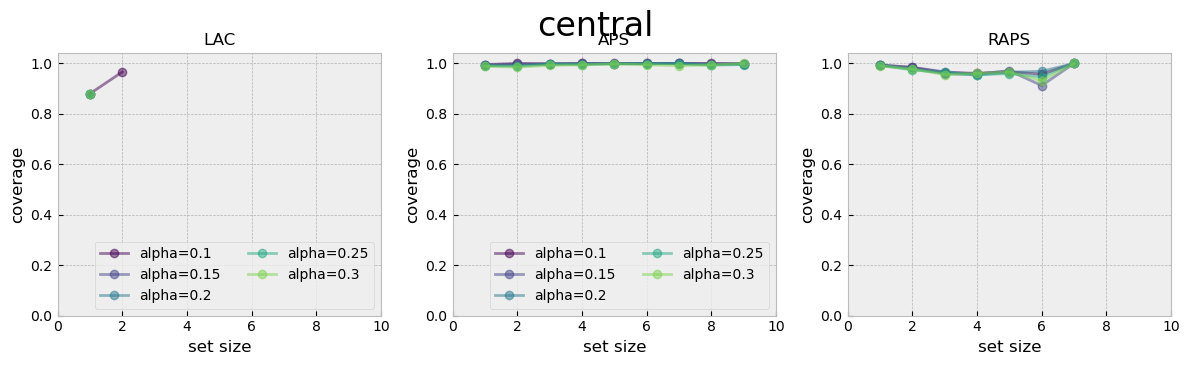

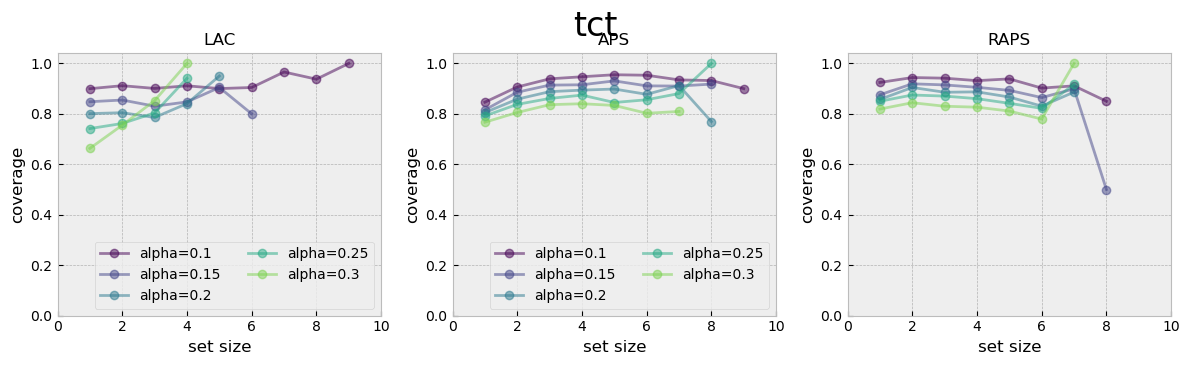

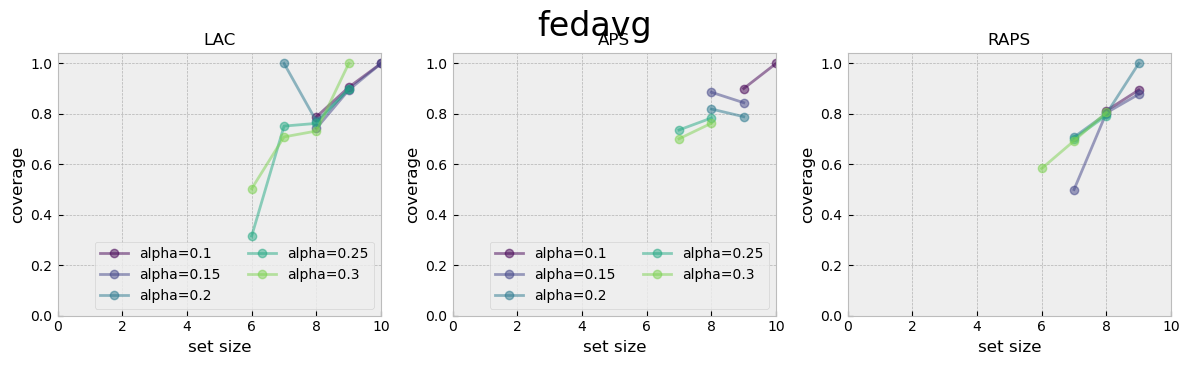

In [689]:
alphas = [0.1, 0.15, 0.2, 0.25, 0.3]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# alphas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
# bins = 15
bins = 2
bins = 1
_alpha = 0.5
# for exp in ('central', 'tct', 'fedavg'):
for exp in experiments.keys():
    val_logits = experiments[exp]['val_scores']
    test_logits = experiments[exp]['test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    temp = tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
    # temp = 1
    val_scores = torch.softmax(val_logits, 1)
    test_scores = torch.softmax(test_logits , 1)
    temp_val_scores = torch.softmax(val_logits / temp, 1)
    temp_test_scores = torch.softmax(test_logits / temp, 1)

    fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
    fig.suptitle(exp, fontsize=24, y=0.90)
    for i, alpha in enumerate(alphas):
        interp_cmap = [round(x) for x in np.linspace(0, 256, len(alphas) + 1)]
        color = mpl.colormaps['viridis'].colors[interp_cmap[i]]
    
        lac_q = calibrate_lac(temp_val_scores, val_targets, alpha=alpha)
        lac_psets = inference_lac(temp_test_scores, lac_q, allow_empty_sets=False)
        aps_q = calibrate_aps(temp_val_scores, val_targets, alpha=alpha)
        aps_psets = inference_aps(temp_test_scores, aps_q, allow_empty_sets=False)
        raps_q = calibrate_raps(temp_val_scores, val_targets, alpha=alpha, k_reg=1, lam_reg=0.01)
        raps_psets = inference_raps(temp_test_scores, raps_q, allow_empty_sets=False, k_reg=1, lam_reg=0.01)
        # size_counts = psets.sum(1).bincount(minlength=num_classes).tolist()
        # ax.scatter(*zip(*size_cond_coverage(psets, test_targets).items()))
        ax[0].plot(*zip(*size_cond_coverage(lac_psets, test_targets, bins=bins, minlength=num_classes).items()), 'o-', label=f'{alpha=}', c=color, alpha=_alpha)
        ax[0].set_title('LAC', fontsize=fontsize)
        ax[0].set_xlabel('set size', fontsize=fontsize)
        ax[0].set_ylabel('coverage', fontsize=fontsize)
        ax[0].set_xlim(0.0, num_classes)
        ax[0].set_ylim(0.0, 1.04)
        ax[1].plot(*zip(*size_cond_coverage(aps_psets, test_targets, bins=bins, minlength=num_classes).items()), 'o-', label=f'{alpha=}', c=color, alpha=_alpha)
        ax[1].set_title('APS', fontsize=fontsize)
        ax[1].set_xlabel('set size', fontsize=fontsize)
        ax[1].set_ylabel('coverage', fontsize=fontsize)
        ax[1].set_xlim(0.0, num_classes)
        ax[1].set_ylim(0.0, 1.04)
        ax[2].plot(*zip(*size_cond_coverage(raps_psets, test_targets, bins=bins, minlength=num_classes).items()), 'o-', label=f'{alpha=}', c=color, alpha=_alpha)
        ax[2].set_title('RAPS', fontsize=fontsize)
        ax[2].set_xlabel('set size', fontsize=fontsize)
        ax[2].set_ylabel('coverage', fontsize=fontsize)
        ax[2].set_xlim(0.0, num_classes)
        ax[2].set_ylim(0.0, 1.04)
        
        ax[0].legend(fontsize=10, loc='lower right', ncol=2)
        ax[1].legend(fontsize=10, loc='lower right', ncol=2)
    fig.tight_layout()
    plt.show()
    # if exp == 'tct': break


## selective classification

In [ ]:
def get_top_k(scores, k=3, return_scores=False):
    # torch.topk()
    sort_index = scores.argsort(1, descending=True)
    sorted_scores = scores.take_along_dim(sort_index, 1)
    top_k_scores = sorted_scores[:, :k]
    mask = torch.zeros_like(scores)
    mask.scatter_(dim=1, index=sort_index[:, :k], src=torch.ones_like(mask))
    mask = mask.bool()
    ret = (mask, top_k_scores) if return_scores else mask
    return ret
   
# for k in range(1, 10):
#     print(f'top_{k} = {coverage(get_top_k(test_scores, k=k), test_targets):.1%}')
fontsize = 20
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
fig.suptitle('top-k coverage', fontsize=fontsize)

# for exp in ('central', 'fedavg', 'tct'):
for exp in experiments.keys():
    val_logits = experiments[exp]['val_scores']
    test_logits = experiments[exp]['test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    temp = tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    
    top_k_coverage = {k: coverage(get_top_k(test_scores, k=k), test_targets) for k in range(1, num_classes)}
    plt.plot(*zip(*top_k_coverage.items()), '-', label=exp)
    
plt.xlabel('set size', fontsize=fontsize)
plt.ylabel('coverage', fontsize=fontsize)
plt.legend()
plt.show()


In [383]:
def get_subset_index(psets, k=10):
    return psets.sum(1) <= k

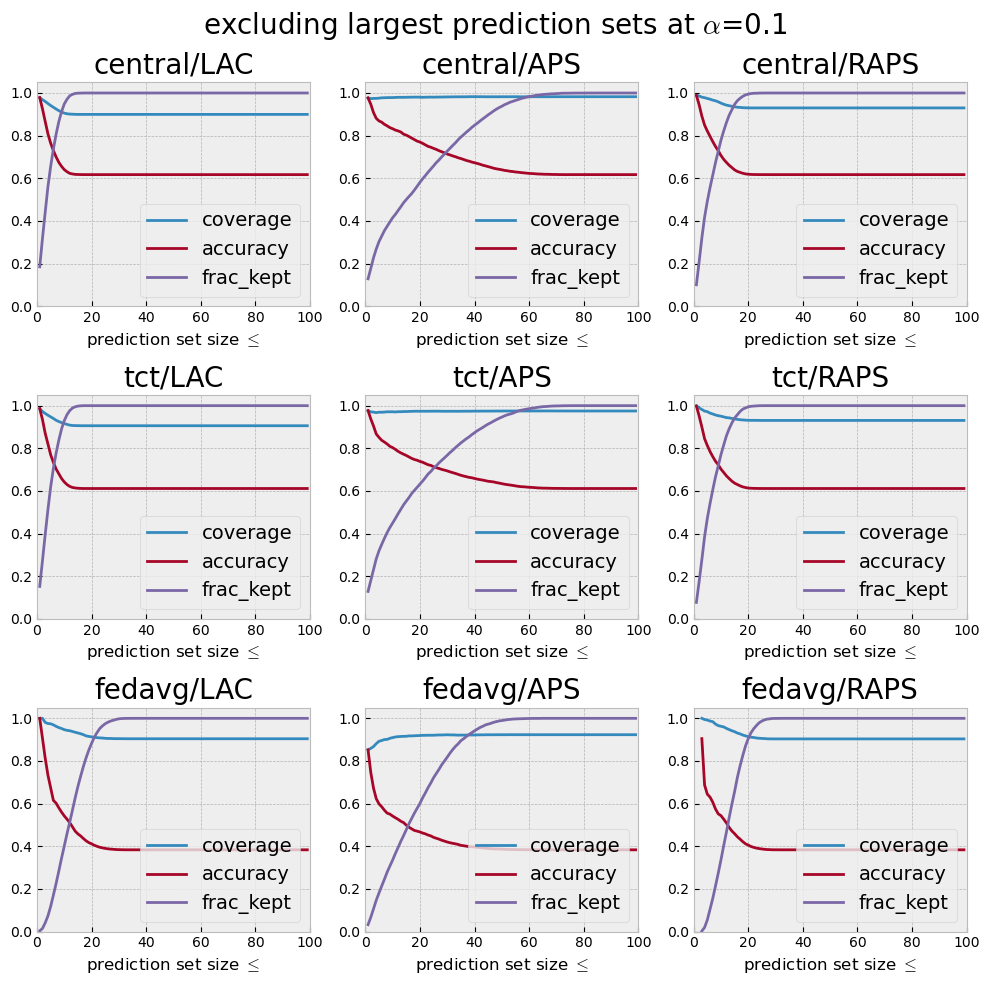

In [486]:
fontsize = 20
# alpha = 0.2

get_frac_kept = itemgetter('frac_kept')
get_coverage = itemgetter('coverage')
get_accuracy = itemgetter('accuracy')

for alpha in (0.1, ):
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
    fig.suptitle(fr'excluding largest prediction sets at $\alpha$={alpha}', fontsize=fontsize)
    for i, exp in enumerate(('central', 'tct', 'fedavg' )):
    # for i, exp in enumerate(experiments.keys()):
        val_logits = experiments[exp]['val_scores']
        test_logits = experiments[exp]['test_scores']
        val_targets = experiments[exp]['val_targets']
        test_targets = experiments[exp]['test_targets']
        temp = tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
        # temp = temp_scale(val_logits, val_targets)
        val_scores = torch.softmax(val_logits / temp, 1)
        test_scores = torch.softmax(test_logits / temp, 1)

        lac_q = calibrate_lac(val_scores, val_targets, alpha=alpha)
        lac_psets = inference_lac(test_scores, lac_q, allow_empty_sets=False)
        lac_size_results = {
            k: {
                'frac_kept': (index.sum() / index.shape[0]).item(),
                'coverage': coverage(lac_psets[index], test_targets[index]),
                'accuracy': accuracy(test_scores[index], test_targets[index]),
            }
            for k in range(0, num_classes, 1)
            if (index := get_subset_index(lac_psets, k)).sum()
        }

        aps_q = calibrate_aps(val_scores, val_targets, alpha=alpha)
        aps_psets = inference_aps(test_scores, aps_q, allow_empty_sets=False)
        aps_size_results = {
            k: {
                'frac_kept': (index.sum() / index.shape[0]).item(),
                'coverage': coverage(aps_psets[index], test_targets[index]),
                'accuracy': accuracy(test_scores[index], test_targets[index]),
            }
            for k in range(0, num_classes, 1)
            if (index := get_subset_index(aps_psets, k)).sum()
        }
        
        raps_q = calibrate_raps(val_scores, val_targets, alpha=alpha, k_reg=1, lam_reg = 0.01)
        raps_psets = inference_raps(test_scores, raps_q, allow_empty_sets=False, k_reg=1, lam_reg = 0.01)
        raps_size_results = {
            k: {
                'frac_kept': (index.sum() / index.shape[0]).item(),
                'coverage': coverage(raps_psets[index], test_targets[index]),
                'accuracy': accuracy(test_scores[index], test_targets[index]),
            }
            for k in range(0, num_classes, 1)
            if (index := get_subset_index(raps_psets, k)).sum()
        }

        style = '-'
        ax[i, 0].plot(*zip(*map(lambda x: (x[0], get_coverage(x[1])), lac_size_results.items())), style, label='coverage')
        ax[i, 0].plot(*zip(*map(lambda x: (x[0], get_accuracy(x[1])), lac_size_results.items())), style, label='accuracy')
        ax[i, 0].plot(*zip(*map(lambda x: (x[0], get_frac_kept(x[1])), lac_size_results.items())), style, label='frac_kept')
        ax[i, 0].set_xlabel(r'prediction set size $\leq$')
        ax[i, 0].set_xlim(0, num_classes)
        # ax[i, 0].set_ylim(0.5, 1.05)
        ax[i, 0].set_ylim(0.0, 1.05)
        ax[i, 0].set_title(exp + '/LAC', fontsize=fontsize)
        # ax[i, 0].legend(fontsize=fontsize-6, loc='lower left')
        ax[i, 0].legend(fontsize=fontsize-6, loc='lower right')


        ax[i, 1].plot(*zip(*map(lambda x: (x[0], get_coverage(x[1])), aps_size_results.items())), style, label='coverage')
        ax[i, 1].plot(*zip(*map(lambda x: (x[0], get_accuracy(x[1])), aps_size_results.items())), style, label='accuracy')
        ax[i, 1].plot(*zip(*map(lambda x: (x[0], get_frac_kept(x[1])), aps_size_results.items())), style, label='frac_kept')
        ax[i, 1].set_xlabel(r'prediction set size $\leq$')
        ax[i, 1].set_xlim(0, num_classes)
        # ax[i, 1].set_ylim(0.5, 1.05)
        ax[i, 1].set_ylim(0.0, 1.05)
        ax[i, 1].set_title(exp + '/APS', fontsize=fontsize)
        # ax[i, 1].legend(fontsize=fontsize-6, loc='lower left')
        ax[i, 1].legend(fontsize=fontsize-6, loc='lower right')

        ax[i, 2].plot(*zip(*map(lambda x: (x[0], get_coverage(x[1])), raps_size_results.items())), style, label='coverage')
        ax[i, 2].plot(*zip(*map(lambda x: (x[0], get_accuracy(x[1])), raps_size_results.items())), style, label='accuracy')
        ax[i, 2].plot(*zip(*map(lambda x: (x[0], get_frac_kept(x[1])), raps_size_results.items())), style, label='frac_kept')
        ax[i, 2].set_xlabel(r'prediction set size $\leq$')
        ax[i, 2].set_xlim(0, num_classes)
        # ax[i, 2].set_ylim(0.5, 1.05)
        ax[i, 2].set_ylim(0.0, 1.05)
        ax[i, 2].set_title(exp + '/RAPS', fontsize=fontsize)
        # ax[i, 2].legend(fontsize=fontsize-6, loc='lower left')
        ax[i, 2].legend(fontsize=fontsize-6, loc='lower right')

    fig.tight_layout()

## Compare score / size per class

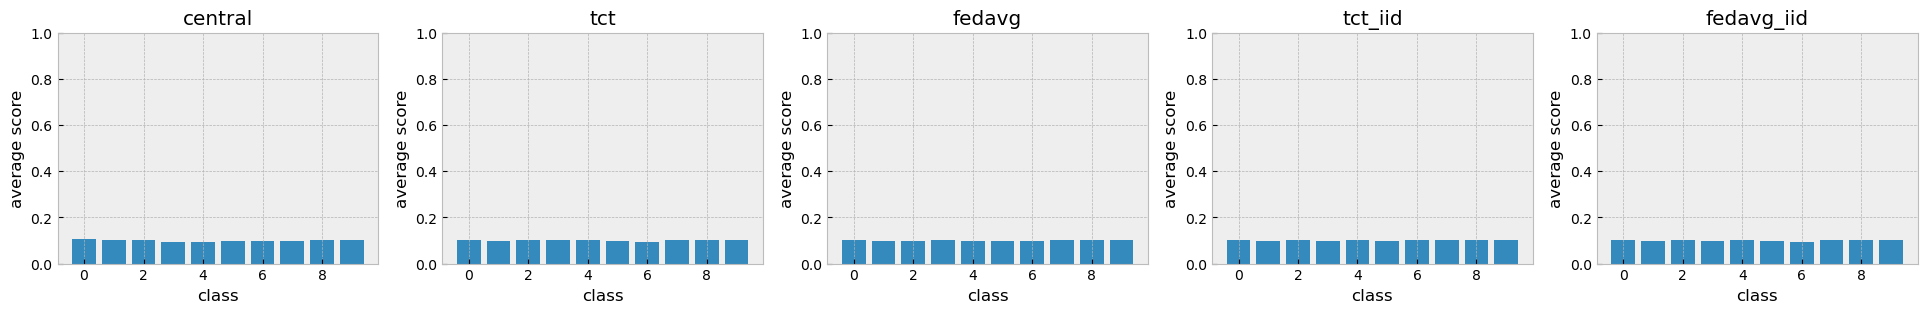

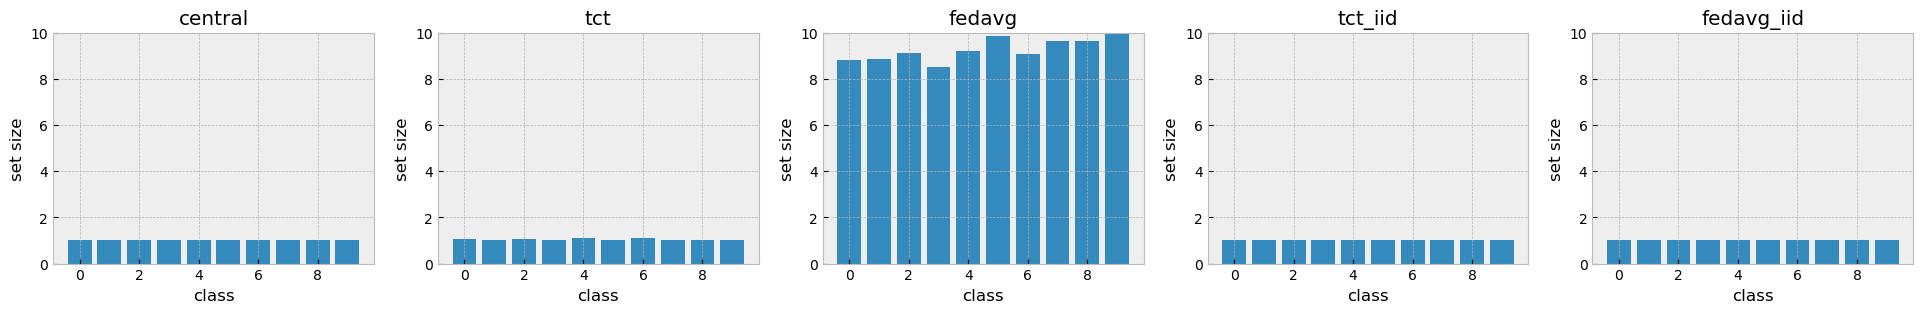

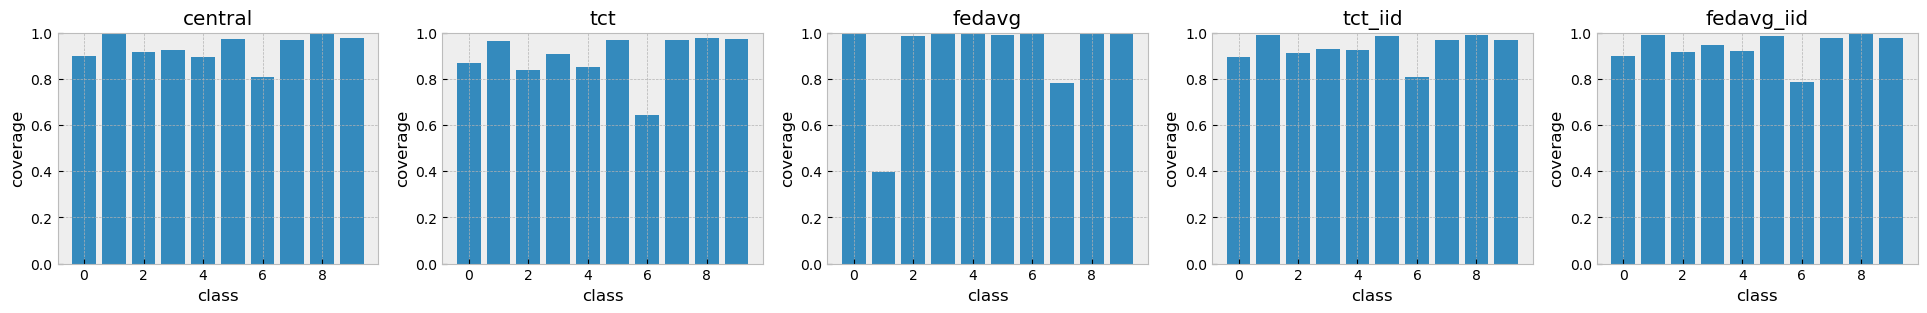

In [812]:
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores
    
    
fig, ax = plt.subplots(ncols=len(experiments), figsize=(24, 3))
for i, exp in enumerate(experiments.keys()):
    # exp = 'central'
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    ax[i].set_title(exp)
    ax[i].bar(range(num_classes), test_scores.mean(0))
    ax[i].set_xlabel('class')
    ax[i].set_ylabel('average score')
    ax[i].set_ylim(0, 1)
    # ax[i].set_ylim(0, .02)
    # plt.bar(range(num_classes), test_scores.std(0))
plt.show()

def efficiency_by_class(psets, targets, num_classes=num_classes):
    sizes = psets.sum(1)
    results = {}
    for c in range(num_classes):
        index = targets == c
        size_c = sizes[index]
        results[c] = size_c.float().mean()
    return results

fig, ax = plt.subplots(ncols=len(experiments), figsize=(24, 3))
for i, exp in enumerate(experiments.keys()):
    # exp = 'central'
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    q = calibrate_lac(val_scores, val_targets, alpha=0.1)
    psets = inference_lac(test_scores, q)

    ax[i].set_title(exp)
    ax[i].bar(range(num_classes), efficiency_by_class(psets, test_targets).values())
    ax[i].set_xlabel('class')
    ax[i].set_ylabel('set size')
    ax[i].set_ylim(0, num_classes)
    # ax[i].set_ylim(0, 20)
    # plt.bar(range(num_classes), test_scores.std(0))
plt.show()

def coverage_by_class(psets, targets, num_classes=num_classes):
    results = {}
    for c in range(num_classes):
        index = targets == c
        pset_c = psets[index]
        target_c = targets[index]
        results[c] = pset_c[torch.arange(target_c.size(0)), target_c].float().mean().item()
    return results


fig, ax = plt.subplots(ncols=len(experiments), figsize=(24, 3))
for i, exp in enumerate(experiments.keys()):
    # exp = 'central'
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    q = calibrate_lac(val_scores, val_targets, alpha=0.1)
    psets = inference_lac(test_scores, q)

    ax[i].set_title(exp)
    ax[i].bar(range(num_classes), coverage_by_class(psets, test_targets).values())
    ax[i].set_xlabel('class')
    ax[i].set_ylabel('coverage')
    ax[i].set_ylim(0., 1)
    # ax[i].set_ylim(0.5, 1)
    # plt.bar(range(num_classes), test_scores.std(0))
plt.show()

# TODO: compare client accuracy curves

In [385]:
def entropy(scores):
    return - torch.sum(scores * torch.log(scores), 1)

Text(0.5, 0, 'softmax entropy')

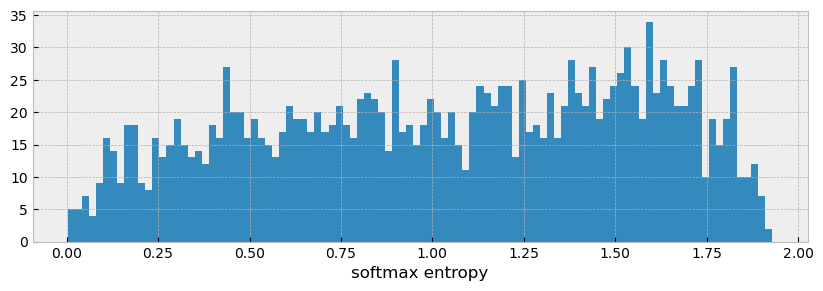

In [386]:
plt.figure(figsize=(10, 3))
plt.hist(entropy(test_scores), bins=100);
plt.xlabel('softmax entropy')

In [287]:
test_ent = entropy(test_scores)
ent_index = test_ent < torch.quantile(test_ent, 1 - alpha)
ent_results = {q:
    ((ent_index.sum() / ent_index.shape[0]).item(), accuracy(test_scores[ent_index], test_targets[ent_index]))
    for q in np.arange(0, 1, 0.01) if (ent_index := test_ent < torch.quantile(test_ent, q)).sum()
}

test_msp = 1 - test_scores.max(1).values
msp_index = test_msp < torch.quantile(test_msp, 1 - alpha)
msp_results = {q:
    ((msp_index.sum() / msp_index.shape[0]).item(), accuracy(test_scores[msp_index], test_targets[msp_index]))
    for q in np.arange(0, 1, 0.01) if (msp_index := test_msp < torch.quantile(test_msp, q)).sum()
}

NameError: name 'lac_size_results' is not defined

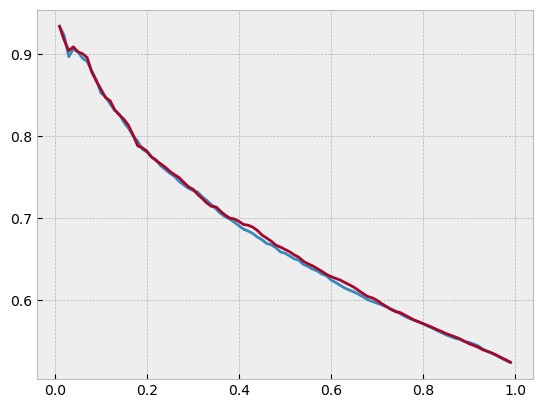

In [288]:
fontsize=10
plt.plot(*zip(*ent_results.values()), '-', label='entropy (accuracy)')
plt.plot(*zip(*msp_results.values()), '-', label='max softmax (accuracy)')
plt.plot(*zip(*(map(lambda x: (get_frac_kept(x), get_accuracy(x)), lac_size_results.values()))), '-', label='size (accuracy)')
plt.plot(*zip(*(map(lambda x: (get_frac_kept(x), get_coverage(x)), lac_size_results.values()))), ':', label='size (coverage)')
plt.legend(fontsize=fontsize)
plt.xlabel('fraction kept', fontsize=fontsize)
# plt.ylabel('accuracy', fontsize=fontsize)
# plt.xlim(0, 0.5)
# plt.ylim(0.8, 1)
plt.show(1)

## Analysis of incorrect classifications and set size

In [899]:
exp = 'tct'
alpha = 0.1

val_logits = experiments[exp]['val_scores']
test_logits = experiments[exp]['test_scores']
val_targets = experiments[exp]['val_targets']
test_targets = experiments[exp]['test_targets']
temp = tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
# temp = temp_scale(val_logits, val_targets)
val_scores = torch.softmax(val_logits / temp, 1)
test_scores = torch.softmax(test_logits / temp, 1)

lac_q = calibrate_lac(val_scores, val_targets, alpha=alpha)
lac_psets = inference_lac(test_scores, lac_q, allow_empty_sets=False)


In [911]:
test_scores[~correct_index]

tensor([[5.3570e-03, 4.3894e-03, 7.5076e-05,  ..., 8.6101e-03, 1.0950e-02,
         8.8138e-03],
        [5.5901e-03, 4.6738e-03, 1.3239e-03,  ..., 7.1403e-04, 3.0753e-03,
         1.3278e-01],
        [1.2327e-01, 1.5357e-03, 2.1097e-04,  ..., 8.0437e-03, 6.2897e-03,
         9.3441e-03],
        ...,
        [3.7692e-03, 1.5309e-03, 2.8608e-03,  ..., 2.5155e-03, 4.3960e-03,
         1.0904e-02],
        [4.2893e-04, 1.2945e-03, 4.2046e-03,  ..., 1.6692e-02, 1.1161e-03,
         1.4926e-03],
        [1.6335e-03, 2.4678e-03, 2.3963e-03,  ..., 3.6125e-03, 1.7167e-02,
         4.0129e-02]])

Text(0, 0.5, 'max score')

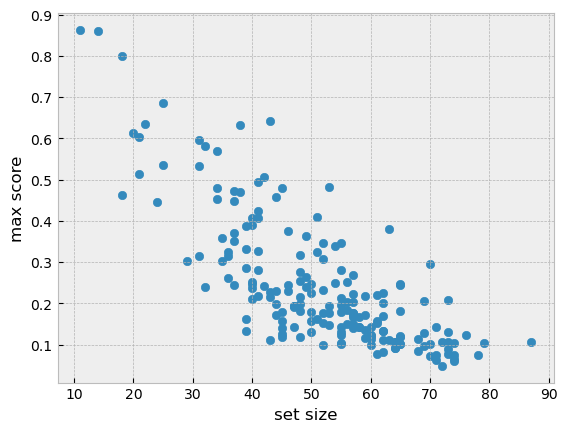

In [914]:
correct_index = lac_psets[torch.arange(test_targets.size(0)), test_targets]

plt.scatter(lac_psets[~correct_index].sum(1), test_scores[~correct_index].max(1).values)
plt.xlabel('set size')
plt.ylabel('max score')

Text(0, 0.5, 'count')

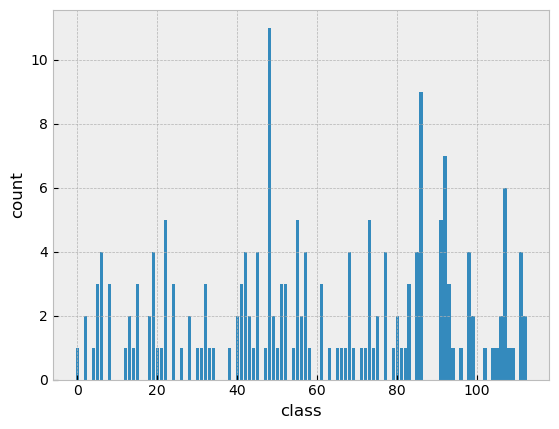

In [924]:
plt.bar(range(113), test_targets[~correct_index].bincount())
plt.xlabel('class')
plt.ylabel('count')

## experiment to check for wrong labels 
1. flip portion of labels
2. use set size to identify wrong labels
3. different levels of hardness

## naive baseline
* uncalibrated lac/aps quantiles
* max softmax probability
* entropy quantile

## effects of data heterogeneity on conformal prediction
* compare IID vs non-IID
* one class label per client

## guidelines / recommendations for CP in FL
* which score function works in data homogenity?

## DDSketch
* plot score distribution to check tails 

In [670]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
data_flag = 'dermamnist'
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [671]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/82802576 [00:00<?, ?it/s]

Using downloaded and verified file: /Users/clu/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/clu/.medmnist/chestmnist.npz


In [672]:
train_dataset.info['label']

{'0': 'atelectasis',
 '1': 'cardiomegaly',
 '2': 'effusion',
 '3': 'infiltration',
 '4': 'mass',
 '5': 'nodule',
 '6': 'pneumonia',
 '7': 'pneumothorax',
 '8': 'consolidation',
 '9': 'edema',
 '10': 'emphysema',
 '11': 'fibrosis',
 '12': 'pleural',
 '13': 'hernia'}

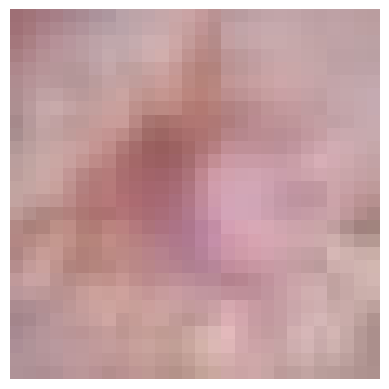

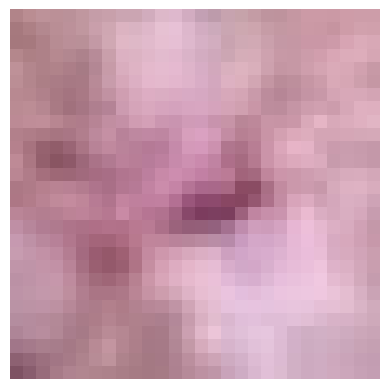

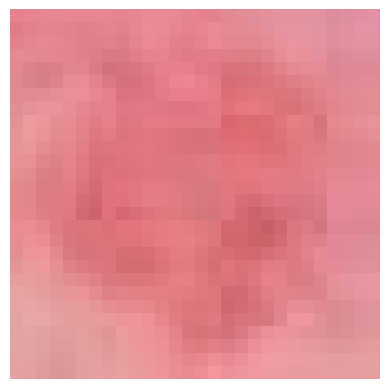

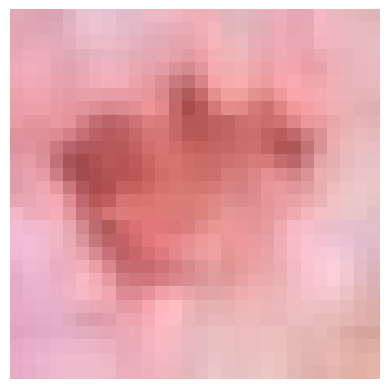

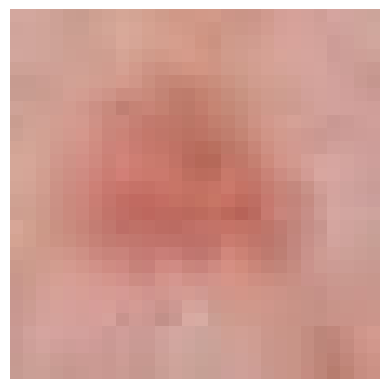

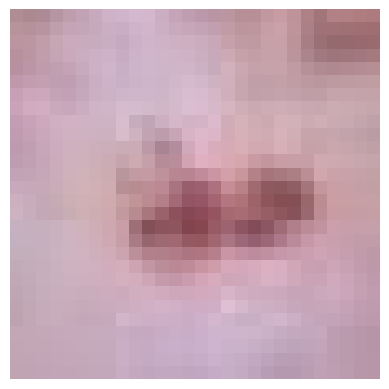

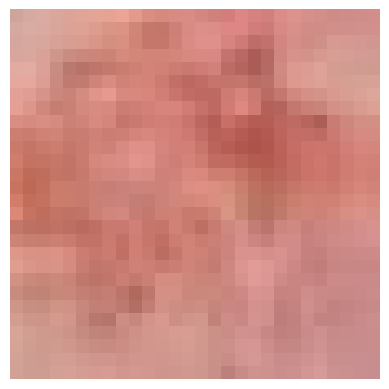

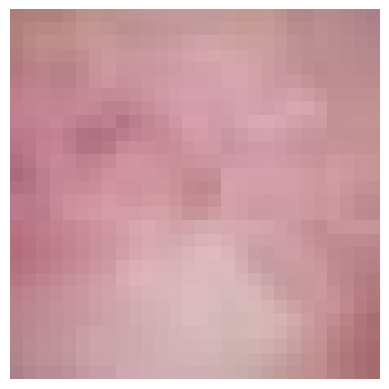

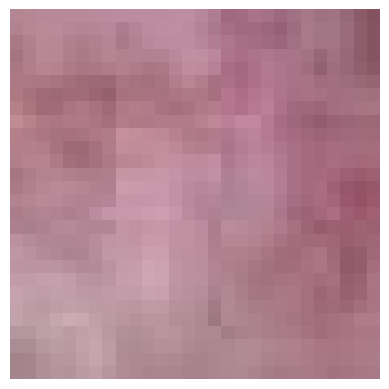

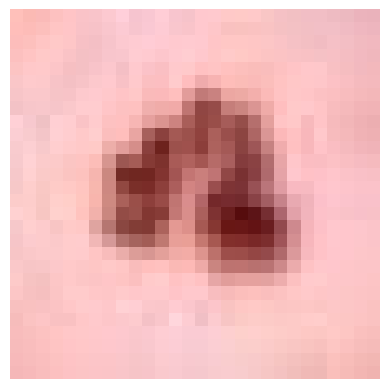

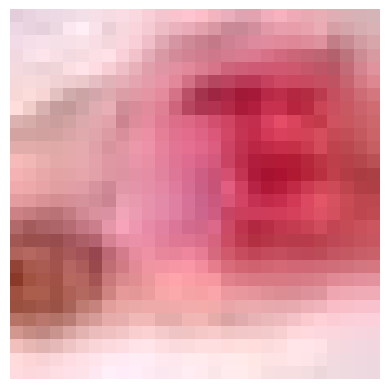

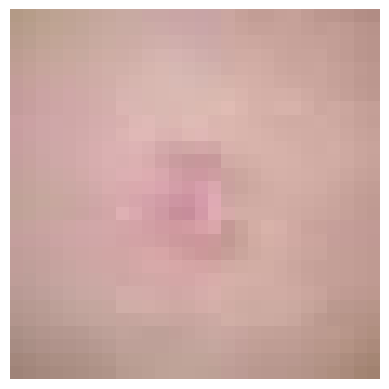

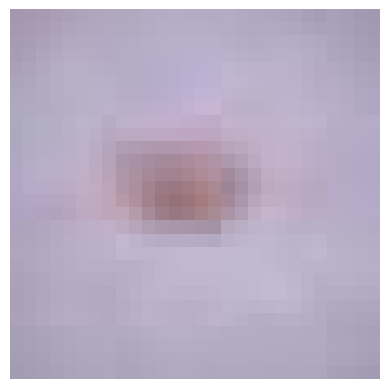

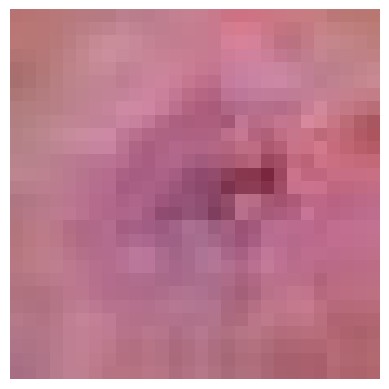

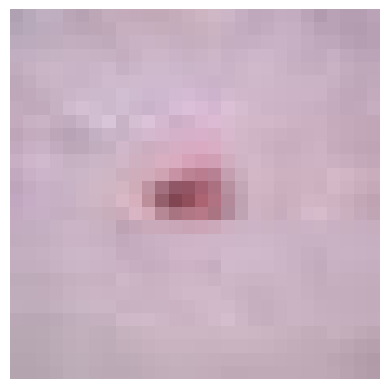

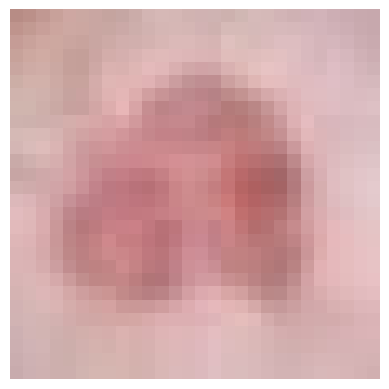

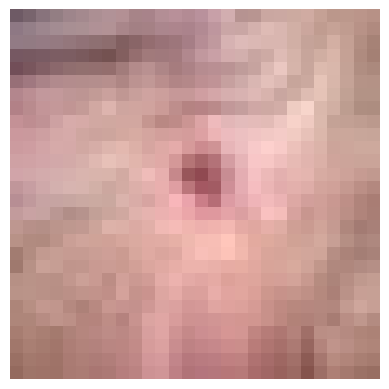

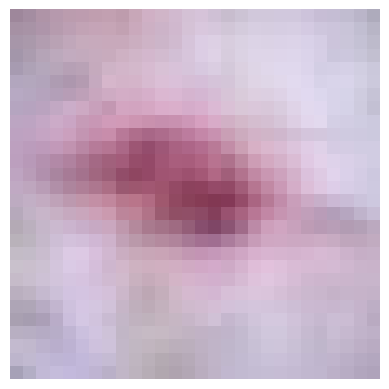

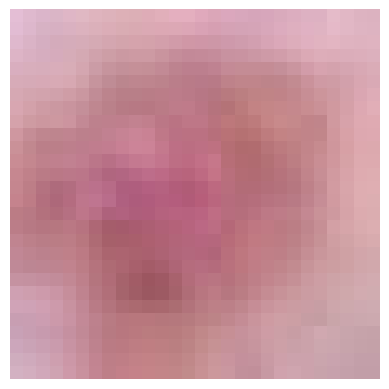

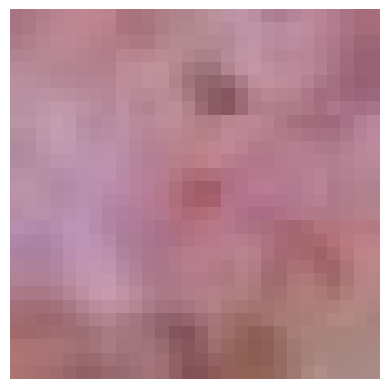

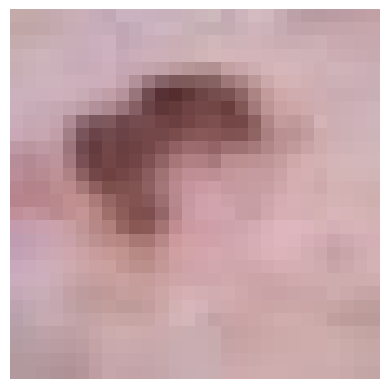

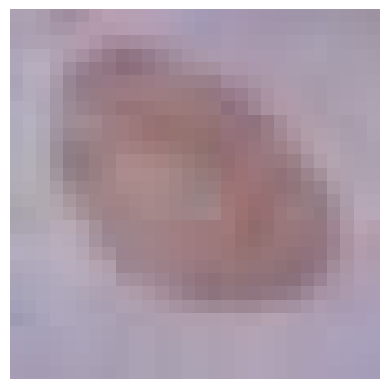

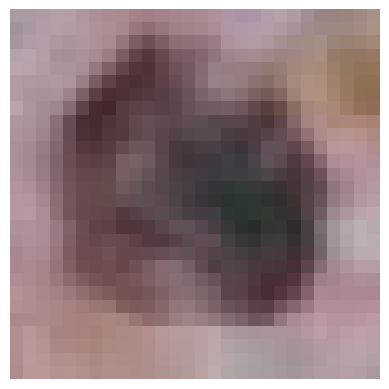

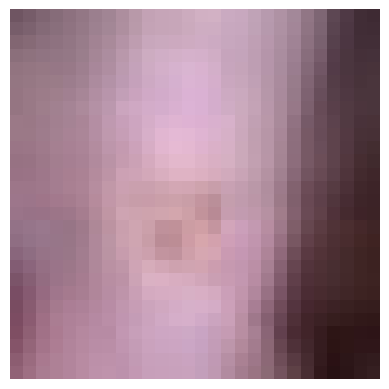

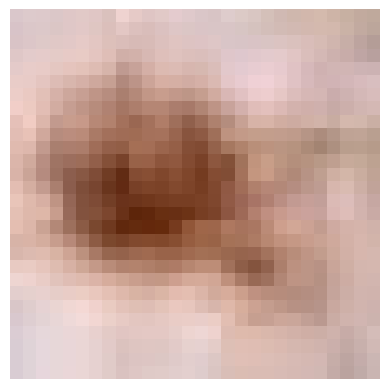

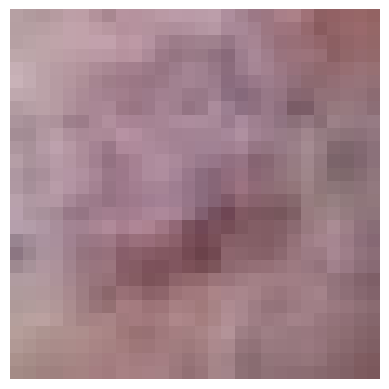

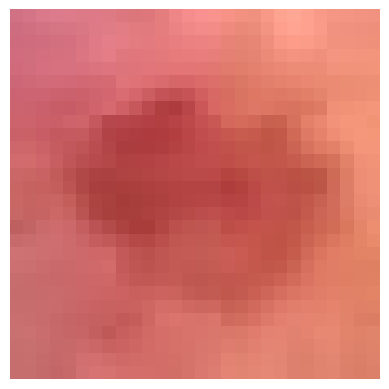

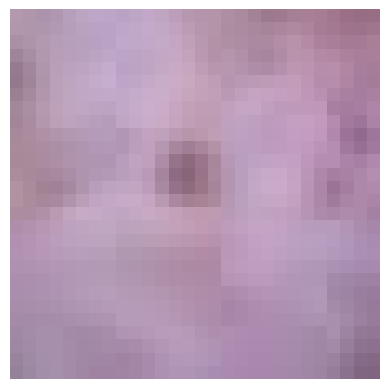

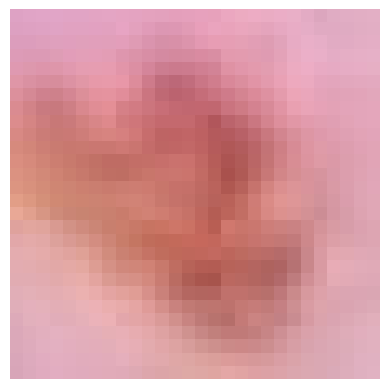

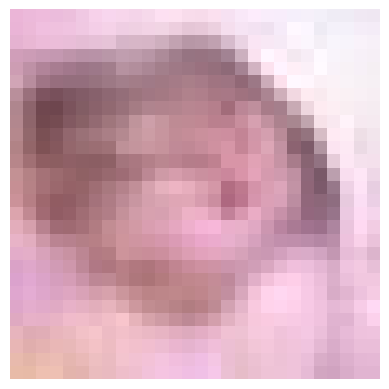

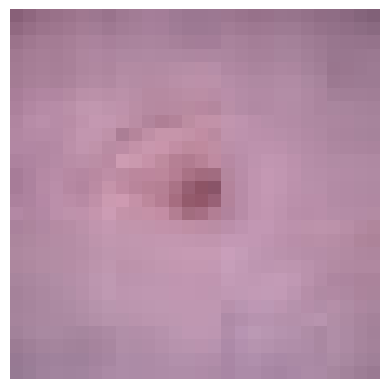

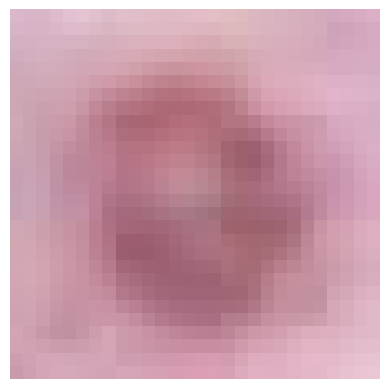

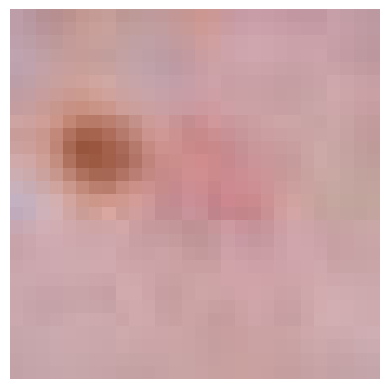

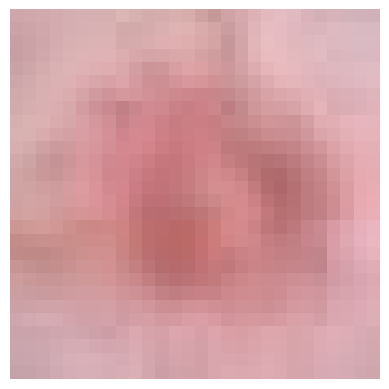

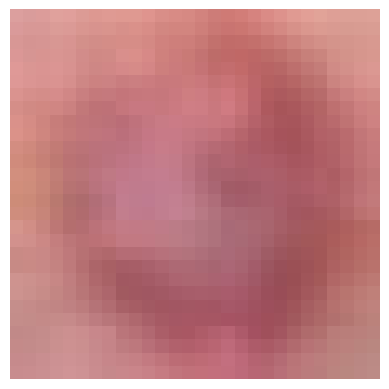

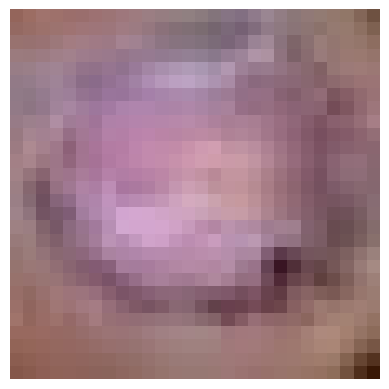

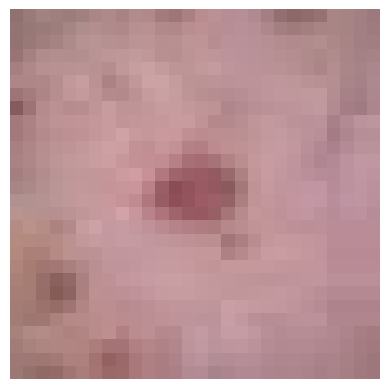

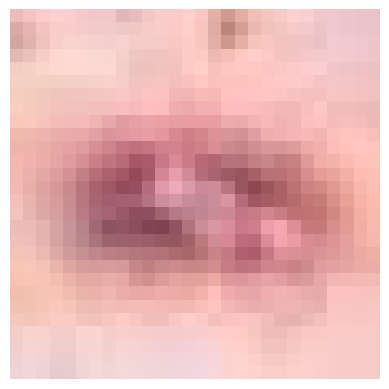

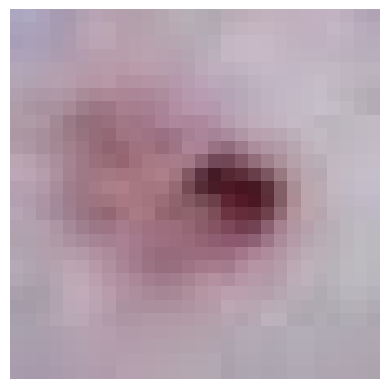

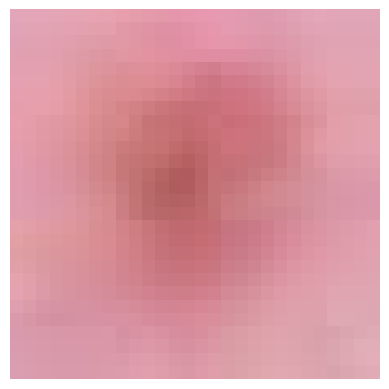

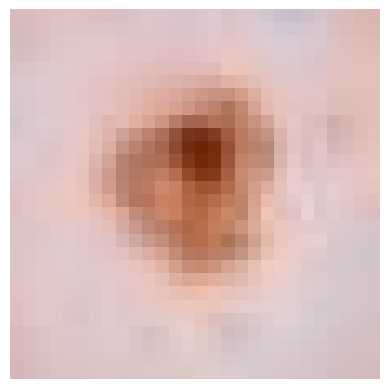

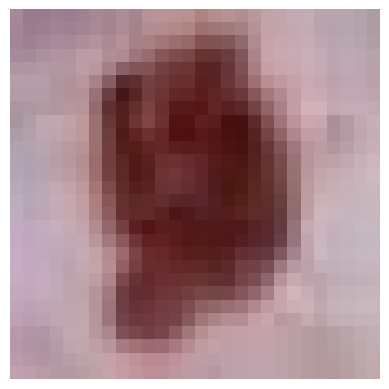

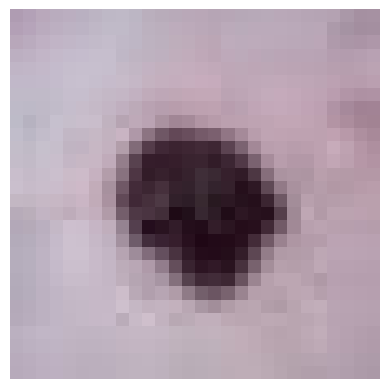

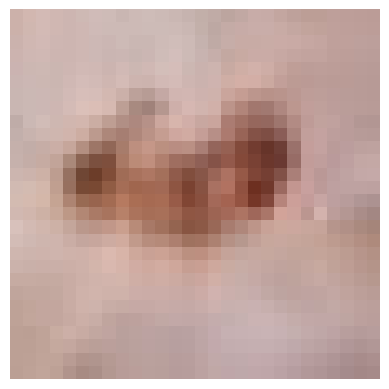

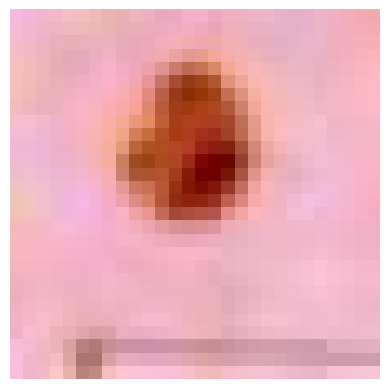

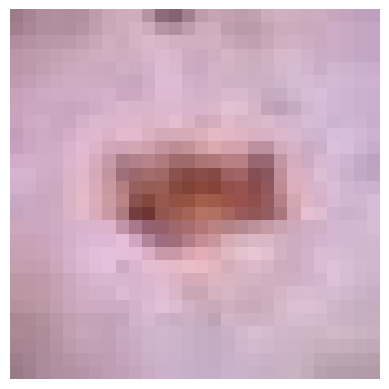

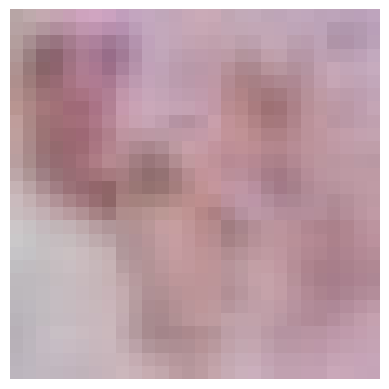

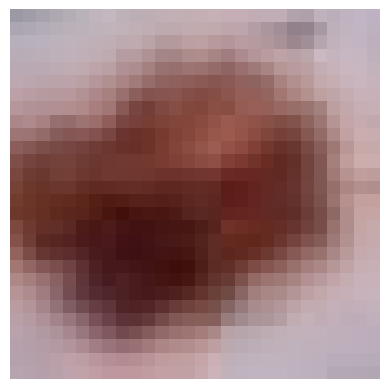

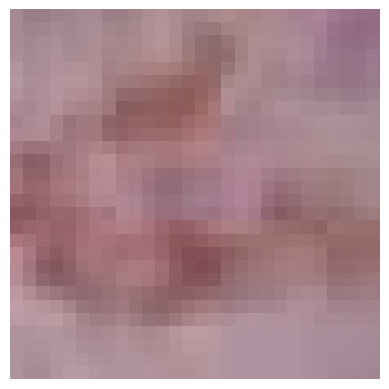

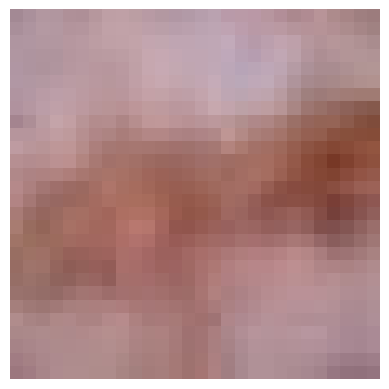

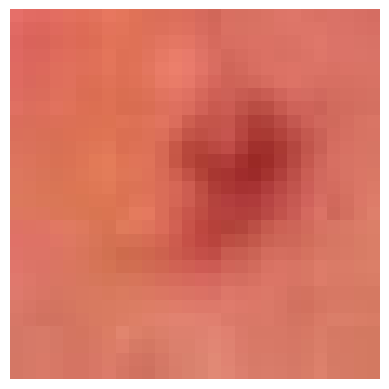

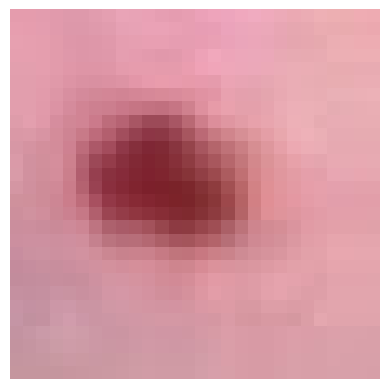

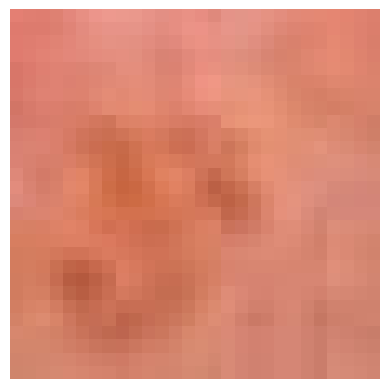

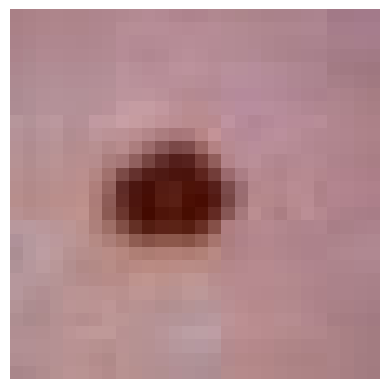

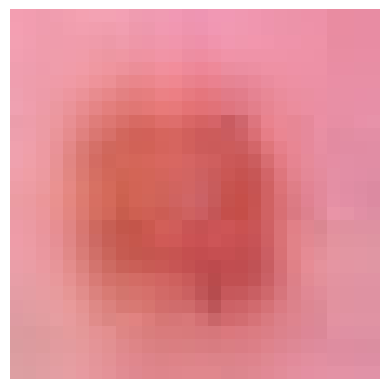

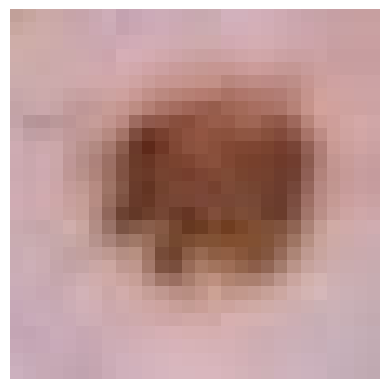

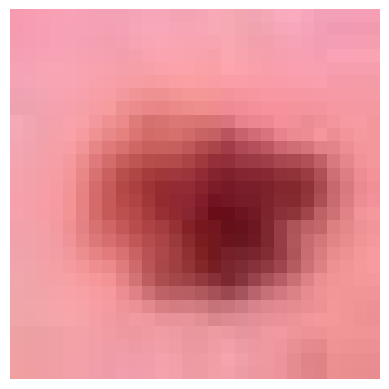

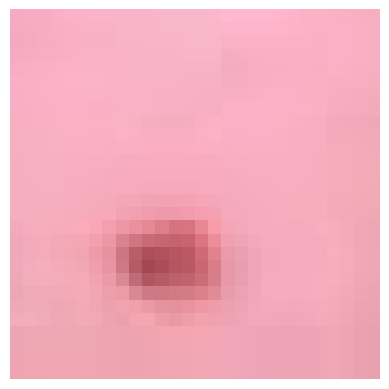

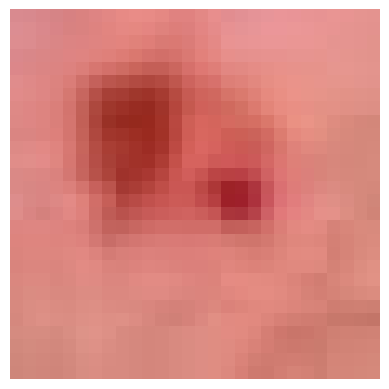

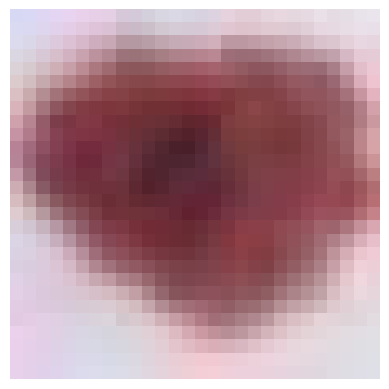

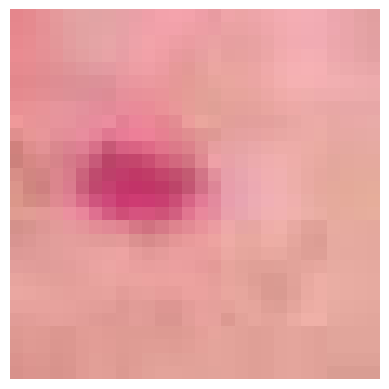

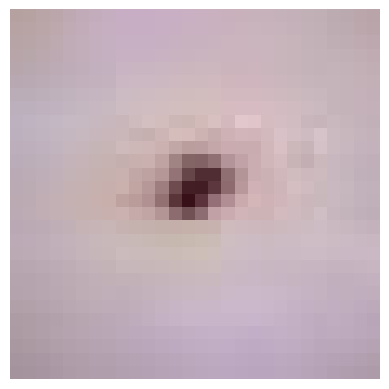

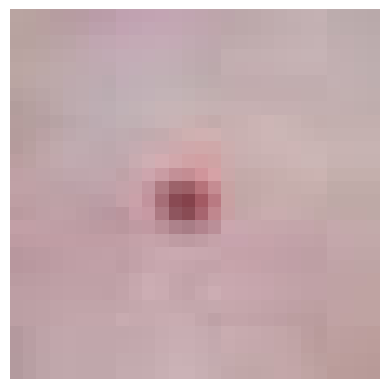

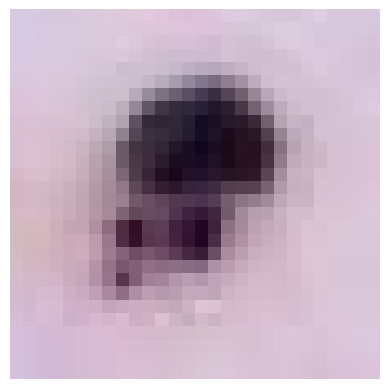

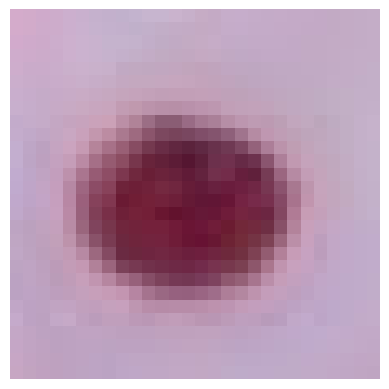

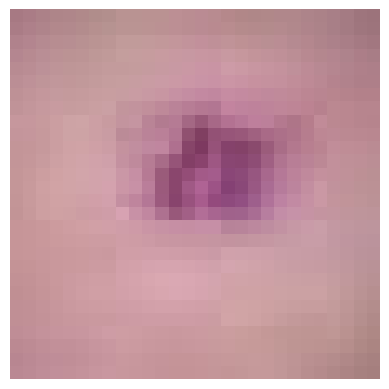

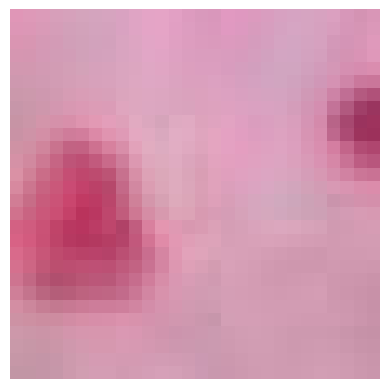

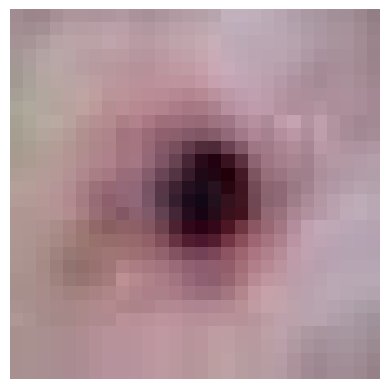

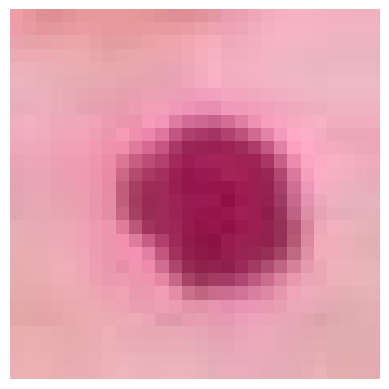

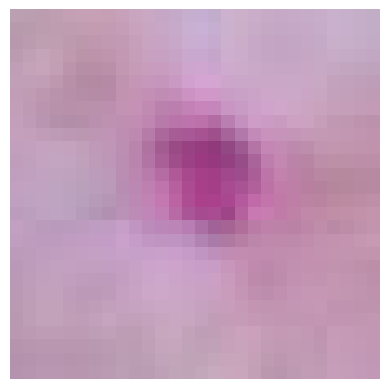

KeyError: '7'

In [669]:
for i in range(8):
    info = train_dataset.info['label'][str(i)]
    for k in range(10):
        index = train_dataset.labels == i
        plt.grid(False)
        plt.axis('off')
        plt.imshow(train_dataset.imgs[index.flatten()][k])
        plt.savefig(f'/Users/clu/Downloads/{info}-{k}.png')
        plt.show()

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

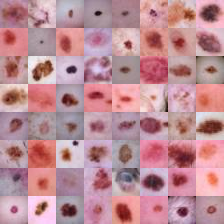

In [636]:
# montage

train_dataset.montage(length=8)